In [282]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
from pathlib import Path
import matplotlib.pyplot as plt
import random
import pandas as pd
from matplotlib import colormaps
import torch.nn.functional as F

from scipy.fft import fft, ifft, fftfreq
from tqdm import tqdm


import dft_lrp  # Your DFTLRP class
import utils.lrp_utils as lrp_utils  # For zennit_relevance
from utils.lrp_utils import zennit_relevance  # Import from DFT-LRP utils
from fft_lrp import FFTLRP


from zennit.attribution import Gradient
from zennit.rules import Epsilon, ZPlus
from zennit.composites import EpsilonPlus

from numpy.fft import rfft, rfftfreq
from scipy.signal import stft



from tqdm import tqdm
import zennit.composites
import zennit.rules
import zennit.core
import zennit.attribution
from zennit.types import Linear
from zennit.composites import LayerMapComposite
from zennit.rules import Epsilon, ZPlus, Pass


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [143]:
class VibrationDataset(Dataset):
    def __init__(self, data_dir, augment_bad=False):
        self.file_paths = []
        self.labels = []
        self.augment_bad = augment_bad

        for label, label_idx in zip(["good", "bad"], [0, 1]):  # 0=good, 1=bad
            folder = os.path.join(data_dir, label)
            for file_name in os.listdir(folder):
                if file_name.endswith(".h5"):
                    self.file_paths.append(os.path.join(folder, file_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        with h5py.File(file_path, "r") as f:
            data = f["vibration_data"][:]  # Shape (2000, 3)

        data = np.transpose(data, (1, 0))  # Change to (3, 2000) for CNN

        label = self.labels[idx]

        # Augment bad samples by adding noise
        if self.augment_bad and label == 1:
            data += np.random.normal(0, 0.01, data.shape)  # Add Gaussian noise

        return torch.tensor(data, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

In [144]:
# ------------------------
# 2️⃣ Define the CNN Model
# ------------------------
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(3, 16, kernel_size=9, stride=1)
        self.gn1 = nn.GroupNorm(4, 16)  # GroupNorm replaces BatchNorm
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=7, stride=1)
        self.gn2 = nn.GroupNorm(4, 32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, stride=1)
        self.gn3 = nn.GroupNorm(4, 64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 2)  # Binary classification

        self.dropout = nn.Dropout(0.4)  # Increased dropout to reduce overfitting
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool1(self.relu(self.gn1(self.conv1(x))))
        x = self.pool2(self.relu(self.gn2(self.conv2(x))))
        x = self.pool3(self.relu(self.gn3(self.conv3(x))))

        x = self.global_avg_pool(x).squeeze(-1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No activation (we use CrossEntropyLoss)

        return x


In [145]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(data_dir, batch_size=64, epochs=20, lr=0.001, weight_decay=1e-4, train_ratio=0.7, val_ratio=0.15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [146]:
# ------------------------
# 3️⃣ Train & Evaluate Functions
# ------------------------
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(train_loader), accuracy


In [147]:
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(val_loader), accuracy

In [148]:
# ------------------------
# 4️⃣ Test the Model
# ------------------------
def test_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Get predicted class

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute F1-score
    f1 = f1_score(all_labels, all_preds, average="weighted")
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    return f1, accuracy


In [149]:
# Splitting the dataset
data_directory = "./data/final/Selected_data_windowed_grouped_normalized_downsampled"

dataset = VibrationDataset(data_directory)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Creating DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [150]:
# ------------------------
# 5️⃣ Full Training Pipeline
# ------------------------
def train_and_evaluate(train_loader, val_loader, test_loader, epochs=20, lr=0.001):

    '''
        # Load dataset and split into train, val, test sets
    dataset = VibrationDataset(data_dir)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    '''

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Model setup
    model = CNN1D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training and validation loop
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    print("✅ Training and validation complete!")

    # Evaluate on the test set
    f1, accuracy = test_model(model, test_loader, device)
    print(f"🔥 Test F1 Score: {f1:.4f}, Test Accuracy: {accuracy:.4f}")

    return model

In [151]:
# ------------------------
# 6️⃣ Run Training & Evaluation
# ------------------------
model = train_and_evaluate(train_loader, val_loader, test_loader)


Epoch [1/20] - Train Loss: 0.6598, Train Acc: 0.6417 - Val Loss: 0.6434, Val Acc: 0.6602
Epoch [2/20] - Train Loss: 0.5948, Train Acc: 0.6979 - Val Loss: 0.6095, Val Acc: 0.6602
Epoch [3/20] - Train Loss: 0.5423, Train Acc: 0.7083 - Val Loss: 0.4924, Val Acc: 0.7282
Epoch [4/20] - Train Loss: 0.4018, Train Acc: 0.8396 - Val Loss: 0.4373, Val Acc: 0.8932
Epoch [5/20] - Train Loss: 0.3426, Train Acc: 0.8750 - Val Loss: 0.2663, Val Acc: 0.8932
Epoch [6/20] - Train Loss: 0.2456, Train Acc: 0.9146 - Val Loss: 0.2605, Val Acc: 0.8835
Epoch [7/20] - Train Loss: 0.1831, Train Acc: 0.9417 - Val Loss: 0.1427, Val Acc: 0.9417
Epoch [8/20] - Train Loss: 0.1479, Train Acc: 0.9458 - Val Loss: 0.1127, Val Acc: 0.9515
Epoch [9/20] - Train Loss: 0.1142, Train Acc: 0.9542 - Val Loss: 0.1059, Val Acc: 0.9709
Epoch [10/20] - Train Loss: 0.1115, Train Acc: 0.9646 - Val Loss: 0.1194, Val Acc: 0.9612
Epoch [11/20] - Train Loss: 0.1095, Train Acc: 0.9604 - Val Loss: 0.0809, Val Acc: 0.9806
Epoch [12/20] - Tra

In [152]:
# Save the trained model
torch.save(model.state_dict(), "cnn1d_model.ckpt")
print("✅ Model saved to cnn1d_model.ckpt")


✅ Model saved to cnn1d_model.ckpt


In [153]:

model.to(device)
model.eval()  # Switch to evaluation mode
print("✅ Model loaded and ready for explanations")


✅ Model loaded and ready for explanations


## XAI

In [154]:
#    Performs a single prediction on input data using the model.
def predict_single(model, x, detach=False):
    """
    Perform a single prediction on input data using the model.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        detach: If True, detach the tensor to avoid retaining the computational graph.
    Returns:
        prediction: Model output logits (before softmax).
        ypred: Predicted class label (0 or 1).
    """
    prediction = model.forward(x.unsqueeze(0)).to(device)  # Add batch dimension
    prediction = prediction[0]  # Remove batch dimension

    if detach:
        prediction = prediction.detach()

    ypred = torch.argmax(prediction).item()  # Predicted class

    return prediction, ypred


In [155]:
def visualize_combined_with_label_attribution(signal, attributions, label, method_name, cmap="bwr"):
    """
    Visualize signal with relevance heatmap and relevance over time in a 3x2 grid,
    including the label and average attribution for each axis over time.
    Args:
        signal: Original input signal (shape: (3, time_steps)).
        attributions: Importance values for explanation (shape: (3, time_steps)).
        label: True label for the sample (e.g., "Good" or "Bad").
        method_name: Name of the explanation method (e.g., "Integrated Gradients").
        cmap: Colormap for relevance (default: "bwr").
    """
    def calculate_average_attribution(attributions):
        """
        Calculate the average attribution for each axis.
        Args:
            attributions: Attribution values (shape: (3, time_steps)).
        Returns:
            A list of average attribution values for each axis.
        """
        averages = [np.mean(attr) for attr in attributions]
        return averages

    if isinstance(attributions, torch.Tensor):
        attributions = attributions.detach().cpu().numpy()

    if isinstance(signal, torch.Tensor):
        signal = signal.detach().cpu().numpy()

    # Calculate average attribution for each axis
    avg_attributions = calculate_average_attribution(attributions)

    axes_labels = ["X", "Y", "Z"]
    fig, axs = plt.subplots(3, 2, figsize=(12, 8))  # 3 rows, 2 columns
    label_text = f"Label: {'Good' if label == 0 else 'Bad'}"



    for i in range(3):  # Loop over axes: X, Y, Z
        time_steps = np.arange(signal[i].shape[0])


        # Find the maximum absolute value for the current axis
        max_abs_value = np.max(np.abs(attributions[i]))
        print(f" Maximum Absolute Attribution in Axis {i}: {max_abs_value}")

        # Map attributions to colors using bwr colormap, scaling between -max_abs_value and +max_abs_value
        norm = plt.Normalize(vmin=-max_abs_value, vmax=max_abs_value)
        cmap = colormaps['bwr']

        # Normalize using -max_abs_value to +max_abs_value to keep zero as white
        '''relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] + max_abs_value) / (2 * max_abs_value))



        # Left column: Signal + Relevance Heatmap
        relevance_colors = plt.cm.get_cmap(cmap)((attributions[i] - np.min(attributions[i])) /
                                                 (np.max(attributions[i]) - np.min(attributions[i])))  # Map to colormap'''

        for t in range(len(time_steps) - 1):
            axs[i, 0].axvspan(time_steps[t], time_steps[t + 1],  color=cmap(norm(attributions[i][t])), alpha=0.5)

        axs[i, 0].plot(time_steps, signal[i], color="black", linewidth=0.8, label="Signal")  # Thinner signal line
        axs[i, 0].set_title(f"{method_name} Heatmap for {axes_labels[i]}-Axis\n{label_text}, Average Attribution{avg_attributions[i]:.4f}")
        axs[i, 0].set_xlabel("Time Steps")
        axs[i, 0].set_ylabel("Signal Value")
        axs[i, 0].legend()

        # Right column: Relevance over Time
        axs[i, 1].bar(time_steps, attributions[i], color=["red" if val > 0 else "blue" for val in attributions[i]],
                      alpha=0.8, width=1.0)
        axs[i, 1].set_title(f"{method_name} Relevance Over Time for {axes_labels[i]}-Axis\n{label_text}")
        axs[i, 1].set_xlabel("Time Steps")
        axs[i, 1].set_ylabel("Relevance Value")

    fig.suptitle(f"Explanation for {method_name} - {label_text}", fontsize=16)  # Add overall title with label
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
    plt.show()


### Baseline XAI

In [156]:
def xai_gradient(model, x, target=None):
    """
    Compute gradients for the given input and target.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
    Returns:
        grad: Gradients w.r.t. input.
        target: Target class used for gradient computation.
    """
    x.requires_grad = True  # Enable gradient computation

    y_pred, y = predict_single(model, x)
    if target is None:
        target = y

    # Compute gradients
    grad, = torch.autograd.grad(y_pred[target], x, y_pred[target])
    # WHICH IS EQUIVALENT TO: y_pred[target].backward(y_pred[target]),  grad = x.grad

    return grad, target


In [157]:
def xai_grad_times_input(model, x, target=None):
    """
    Compute Grad*Input explanation for the given input.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
    Returns:
        attribution: Grad*Input attributions.
    """
    grad, target = xai_gradient(model, x, target)

    return grad * x, target  # Multiply gradients by input


In [158]:
def xai_smoothgrad(model, x, num_samples=40, noise_level=3, target=None): # num_sample = 200 for normal signal, for sownsampled=40
    """
    Compute SmoothGrad explanation for the given input.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        num_samples: Number of noisy samples to generate (default: 200).
        noise_level: Standard deviation of added noise (default: 3).
        target: Target class for explanation (default: model's prediction).
    Returns:
        sgrad: SmoothGrad attributions (averaged gradients).
        target: Target class used for explanation.
    """
    # Compute gradients for the original signal
    sgrad, target = xai_gradient(model, x, target)

    # Add noisy samples and accumulate gradients
    for i in range(1, num_samples):
        noisy_x = torch.clone(x.detach()) + torch.randn_like(x) * noise_level
        sgrad += xai_gradient(model, noisy_x, target)[0]

    # Average accumulated gradients
    sgrad /= num_samples

    return sgrad * x, target


In [159]:
def xai_occlusion_signal(model, x, target=None, occlusion_type="zero"):
    """
    Compute occlusion-based explanation for time-series signal.
    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
        occlusion_type: Type of occlusion ("zero", "one", "mone", "flip").
    Returns:
        attribution: Occlusion-based attributions (3, time_steps).
    """
    def zero(_): return 0
    def one(_): return 1
    def mone(_): return -1
    def flip(val): return -val

    occlusion_fxns = {"zero": zero, "one": one, "mone": mone, "flip": flip}
    assert occlusion_type in occlusion_fxns, f"Invalid occlusion type: {occlusion_type}"

    # Original prediction
    x_0 = x.detach().clone()
    pred_0, y_0 = predict_single(model, x_0, detach=True)
    if target is None:
        target = y_0

    # Prepare attribution mask
    attributions = torch.zeros_like(x)

    # Iterate over time steps and axes
    for feature_idx in range(x.shape[0]):  # X, Y, Z axes
        for time_idx in range(x.shape[1]):  # Time steps
            x_copy = x.clone()
            x_copy[feature_idx, time_idx] = occlusion_fxns[occlusion_type](x_copy[feature_idx, time_idx])
            pred, _ = predict_single(model, x_copy, detach=True)
            attributions[feature_idx, time_idx] = pred_0[target] - pred[target]

    return attributions, target


In [160]:
def xai_occlusion_simple(model, x, target=None, occlusion_type="zero", window_size=40):  #windowsize=40 for downsampled, 200 for normal signal
    """
    Compute occlusion-based explanation for time-series signals.

    Args:
        model: Trained PyTorch model.
        x: Input tensor (time-series signal, shape: (3, time_steps)).
        target: Target class for explanation (default: model's prediction).
        occlusion_type: Type of occlusion ("zero", "one", "mone", "flip").
        window_size: Number of consecutive time steps to occlude.

    Returns:
        attribution: Occlusion-based attributions (3, time_steps).
    """
    def zero(_): return 0      # Replace occluded time points with 0
    def one(_): return 1       # Replace occluded time points with 1
    def mone(_): return -1     # Replace occluded time points with -1
    def flip(val): return -val # Flip the sign of the original value

    occlusion_fxns = {"zero": zero, "one": one, "mone": mone, "flip": flip}
    assert occlusion_type in occlusion_fxns, f"Invalid occlusion type: {occlusion_type}"

    # Get the original prediction before occlusion
    x_0 = x.detach().clone()
    pred_0, y_0 = predict_single(model, x_0, detach=True)
    if target is None:
        target = y_0  # Use model's prediction if no target is provided

    # Prepare attribution mask (same shape as input)
    attributions = torch.zeros_like(x)

    # Iterate over time steps in window_size chunks
    for i in range(0, x.shape[1], window_size):  # Slide occlusion window
        x_copy = x.clone()  # Copy original input

        for feature_idx in range(x.shape[0]):  # X, Y, Z axes
            x_copy[feature_idx, i:i+window_size] = occlusion_fxns[occlusion_type](x_copy[feature_idx, i:i+window_size])

        # Get new prediction after occlusion
        pred, _ = predict_single(model, x_copy, detach=True)

        # Compute attribution: Difference in target class probability
        attributions[:, i:i+window_size] = pred_0[target] - pred[target]

    return attributions, target


In [161]:
print(model)


CNN1D(
  (conv1): Conv1d(3, 16, kernel_size=(9,), stride=(1,))
  (gn1): GroupNorm(4, 16, eps=1e-05, affine=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(7,), stride=(1,))
  (gn2): GroupNorm(4, 32, eps=1e-05, affine=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (gn3): GroupNorm(4, 64, eps=1e-05, affine=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (relu): ReLU()
)


In [162]:
def summarize_attributions(attributions):
    """
    Summarize the positive and negative attributions for each axis, including counts, averages, and totals.
    Args:
        attributions: Attribution values (shape: (3, time_steps)).
    Returns:
        summary: Dictionary with detailed attribution statistics per axis.
    """
    summary = {}
    for axis, attr in enumerate(attributions):
        # Positive relevance
        positive_values = attr[attr > 0]
        positive_count = len(positive_values)
        total_positive_relevance = np.sum(positive_values)
        average_positive_relevance = total_positive_relevance / positive_count if positive_count > 0 else 0

        # Negative relevance
        negative_values = attr[attr < 0]
        negative_count = len(negative_values)
        total_negative_relevance = np.sum(negative_values)
        average_negative_relevance = total_negative_relevance / negative_count if negative_count > 0 else 0

        # Total relevance (positive + negative)
        total_relevance = total_positive_relevance + total_negative_relevance
        total_count = positive_count + negative_count
        average_relevance = total_relevance / total_count if total_count > 0 else 0

        # Store results
        summary[f"Axis {axis}"] = {
            "Positive Count": positive_count,

            "Total Positive Relevance": total_positive_relevance,

            "Average Positive Relevance": average_positive_relevance,

            "Negative Count": negative_count,

            "Total Negative Relevance": total_negative_relevance,

            "Average Negative Relevance": average_negative_relevance,

            "Total Relevance (Pos + Neg)": total_relevance,

            "Average Relevance (Pos + Neg)": average_relevance,
        }
    return summary



#### Explain with LRP

In [163]:
def compute_lrp_relevance_single_sample(model, sample, label=None, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Compute LRP relevances for a single vibration sample.

    Args:
        model: Trained CNN1D model
        sample: Numpy array or torch tensor of shape (3, 10000) for the vibration data   (3,2000) for downsampled
        label: Optional integer label (0 or 1) for the sample. If None, use model prediction as target
        device: Torch device (CPU or CUDA)

    Returns:
        relevance: Numpy array of shape (3, 10000) containing LRP relevances
        input_signal: Numpy array of the input signal (for visualization)
        predicted_label: Predicted label if label is None
    """
    # Ensure sample is a PyTorch tensor with shape (1, 3, 10000)
    if isinstance(sample, np.ndarray):
        sample = torch.tensor(sample, dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dimension and move to device
    else:
        sample = sample.to(device).unsqueeze(0)  # Assume it's already a tensor, add batch dimension and move to device

    # Move model to the specified device (already done in your script, but ensure consistency)
    model = model.to(device)
    model.eval()

    # Debug: Print device information
    print(f"Sample device: {sample.device}")
    print(f"Model device: {next(model.parameters()).device}")

    # If no label provided, use model prediction as target
    if label is None:
        with torch.no_grad():
            outputs = model(sample)
            _, predicted_label = torch.max(outputs, 1)  # Get predicted class (0 or 1)
        target = predicted_label.item()
    else:
        target = label  # Use provided label as target
        target = torch.tensor([target], device=device)  # Ensure target is on the same device

    # Debug: Print target device
    print(f"Target device: {target.device}")

    # Compute LRP relevances using Zennit
    try:
        relevance = zennit_relevance(
            input=sample,
            model=model,
            target=target,  # Target is already on the correct device
            attribution_method="lrp",  # Use LRP
            zennit_choice="EpsilonPlus",  # Use EpsilonPlus rule (stable for neural networks)
            rel_is_model_out=True,  # Relevance is model output (logits)
            cuda=(device == "cuda")
        )
    except RuntimeError as e:
        print(f"Error in zennit_relevance: {e}")
        raise

    # Remove batch dimension and convert to numpy
    relevance = relevance.squeeze(0)  # Shape: (3, 10000)
    input_signal = sample.squeeze(0).detach().cpu().numpy()  # Shape: (3, 10000)

    return relevance, input_signal, target.item() if label is None else label

In [164]:
# 8️⃣ Visualize LRP Relevances for a Single Sample
# ------------------------
def visualize_lrp_relevance_single_sample(signal, relevance, label, sample_idx=0, axes_names=["X", "Y", "Z"]):
    """
    Visualize a single sample's signal and LRP relevance for each axis.

    Args:
        signal: Numpy array of shape (3, 10000) for the time series
        relevance: Numpy array of shape (3, 10000) for LRP relevances
        label: Integer label (0 or 1) for the sample
        sample_idx: Index of the sample (for title, defaults to 0 for single sample)
        axes_names: List of axis names for labeling
    """
    n_axes = signal.shape[0]
    fig, axs = plt.subplots(n_axes, 2, figsize=(12, 4 * n_axes))

    for i in range(n_axes):
        # Plot signal
        axs[i, 0].plot(signal[i], label=f"Signal ({axes_names[i]})")
        axs[i, 0].set_title(f"Signal - Axis {axes_names[i]} (Sample {sample_idx}, Label: {'Good' if label == 0 else 'Bad'})")
        axs[i, 0].set_xlabel("Time Step")
        axs[i, 0].set_ylabel("Amplitude")
        axs[i, 0].legend()

        # Plot relevance (positive in blue, negative in red)
        axs[i, 1].fill_between(range(len(relevance[i])), relevance[i], where=relevance[i] > 0, color='red', alpha=0.5, label='Positive Relevance')
        axs[i, 1].fill_between(range(len(relevance[i])), relevance[i], where=relevance[i] < 0, color='blue', alpha=0.5, label='Negative Relevance')
        axs[i, 1].set_title(f"LRP Relevance - Axis {axes_names[i]}")
        axs[i, 1].set_xlabel("Time Step")
        axs[i, 1].set_ylabel("Relevance")
        axs[i, 1].legend()

    plt.tight_layout()
    plt.show()

#### DFT-LRP

In [289]:
def compute_lrp_relevance_with_dft(
    model,
    sample,
    label=None,
    device="cuda" if torch.cuda.is_available() else "cpu",
    signal_length=2000,  # Updated to match downsampled data
    leverage_symmetry=True,
    precision=32,
    create_stdft=False,
    create_inverse=False,
    sampling_rate=400  # Adjusted based on downsampling assumption
):
    """
    Compute LRP relevances for a single vibration sample in both time and frequency domains.

    Args:
        model: Trained CNN1D model
        sample: Numpy array or torch tensor of shape (3, 10000) for the vibration data
        label: Optional integer label (0 or 1). If None, use model prediction
        device: Torch device (CPU or CUDA)
        signal_length: Length of the signal (10000 for your dataset)
        batch_size: Batch size for DFT-LRP processing
        leverage_symmetry: Use symmetry in DFT (reduces frequency bins to positive frequencies)
        precision: 32 or 16 for DFTLRP
        create_stdft: Whether to create STDFT layers (not needed for now)
        create_inverse: Whether to create inverse DFT layers (not needed for now)
        sampling_rate: Sampling rate of the data in Hz (e.g., 10000 for 10 kHz)

    Returns:
        relevance_time: Numpy array of shape (3, 10000) with time-domain relevances  [3,2000 for downssampled]
        relevance_freq: Numpy array of shape (3, 5001) with frequency-domain relevances
        signal_freq: Numpy array of shape (3, 5001) with frequency-domain signal
        input_signal: Numpy array of shape (3, 10000) with the input signal
        freqs: Frequency bins (for visualization)
        predicted_label: Predicted label if label is None
    """
    # Ensure sample is a PyTorch tensor with shape (1, 3, 10000)
    if isinstance(sample, np.ndarray):
        sample = torch.tensor(sample, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        sample = sample.to(device).unsqueeze(0)

    model = model.to(device)
    model.eval()

    # If no label provided, use model prediction as target
    if label is None:
        with torch.no_grad():
            outputs = model(sample)
            _, predicted_label = torch.max(outputs, 1)
        target = predicted_label.item()
    else:
        target = label.item() if isinstance(label, torch.Tensor) else label
        target = torch.tensor([target], device=device)

    # Compute LRP relevances in the time domain using Zennit
    relevance_time = lrp_utils.zennit_relevance(
        input=sample,
        model=model,
        target=target,
        attribution_method="lrp",
        zennit_choice="EpsilonPlus",
        rel_is_model_out=True,
        cuda=(device == "cuda")
    )
    relevance_time = relevance_time.squeeze(0)  # Shape: (3, 10000)
    input_signal = sample.squeeze(0).detach().cpu().numpy()  # Shape: (3, 10000)

    # Initialize DFTLRP for frequency-domain propagation
    dftlrp = dft_lrp.DFTLRP(
        signal_length=signal_length,
        leverage_symmetry=leverage_symmetry,
        precision=precision,
        cuda=(device == "cuda"),
        create_stdft=create_stdft,
        create_inverse=create_inverse
    )

    # Prepare for frequency-domain propagation
    n_axes = input_signal.shape[0]  # 3 (X, Y, Z)
    print(n_axes)
    freq_length = signal_length // 2 + 1 if leverage_symmetry else signal_length  # 5001 with symmetry
    print(freq_length)
    signal_freq = np.empty((n_axes, freq_length), dtype=np.complex128)
    relevance_freq = np.empty((n_axes, freq_length))

    # Process each axis separately
    for axis in range(n_axes):
        signal_axis = input_signal[axis:axis+1, :]
        relevance_axis = relevance_time[axis:axis+1, :]
        signal_freq_axis, relevance_freq_axis = dftlrp.dft_lrp(
            relevance=relevance_axis,
            signal=signal_axis,
            real=False,
            short_time=False,
            epsilon=1e-6
        )
        signal_freq[axis] = signal_freq_axis[0]
        relevance_freq[axis] = relevance_freq_axis[0]

    # Compute frequency bins for visualization
    freqs = fftfreq(signal_length, d=1.0/sampling_rate)[:freq_length]  # Scaled by sampling rate

    # Clean up to free memory
    del dftlrp

    return relevance_time, relevance_freq, signal_freq, input_signal, freqs, target.item() if label is None else label

#

In [290]:
 # Visualization function for time and frequency domains
def visualize_lrp_time_freq(
    relevance_time,
    relevance_freq,
    signal_freq,
    input_signal,
    freqs,
    predicted_label,
    axes_names=["X", "Y", "Z"],
    k_max=1000,  # Increased to 1000 Hz for better range
    signal_length=2000,   #10000 if we did not downsampled
    sampling_rate=400  # Placeholder, replace with your actual sampling rate   2000 for not downsampled
):
    """
    Visualize LRP relevances in time and frequency domains for each axis with enhanced readability.

    Args:
        relevance_time: Numpy array of shape (3, 10000) with time-domain relevances
        relevance_freq: Numpy array of shape (3, 5001) with frequency-domain relevances
        signal_freq: Numpy array of shape (3, 5001) with frequency-domain signal
        input_signal: Numpy array of shape (3, 10000) with the input signal
        freqs: Frequency bins (length 5001)
        predicted_label: Predicted or true label
        axes_names: Names of the axes (X, Y, Z)
        k_max: Maximum frequency index to plot (in Hz)
        signal_length: Length of the signal
        sampling_rate: Sampling rate of the data in Hz
    """
    n_axes = input_signal.shape[0]  # 3 (X, Y, Z)
    nrows, ncols = n_axes, 4  # 4 columns: signal (time), relevance (time), signal (freq), relevance (freq)
    figsize = (ncols * 6, nrows * 5)  # Increased size for better readability
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

    def replace_positive(x, positive=True):  #replaces positive(or negative if positive=false) values with zero
        mask = x > 0 if positive else x < 0
        x_mod = x.copy()
        x_mod[mask] = 0
        return x_mod

    # Plot for each axis
    for i in range(n_axes):
        # Time domain: Signal
        x_time = np.linspace(0, signal_length, signal_length)
        ax[i, 0].plot(x_time, input_signal[i])
        ax[i, 0].set_xlabel("Time Steps ($n$)", fontsize=12)
        ax[i, 0].set_ylabel("Amplitude ($x_n$)", fontsize=12)
        ax[i, 0].set_title(f"Signal (Time) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 0].grid(True)

        # Time domain: Relevance
        ax[i, 1].fill_between(x_time, replace_positive(relevance_time[i], positive=False), color="red", label="Positive")
        ax[i, 1].fill_between(x_time, replace_positive(relevance_time[i]), color="blue", label="Negative")
        ax[i, 1].set_xlabel("Time Steps ($n$)", fontsize=12)
        ax[i, 1].set_ylabel("Relevance ($R_n$)", fontsize=12)
        ax[i, 1].set_title(f"LRP Relevance (Time) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 1].legend(fontsize=10, loc="upper right")
        ax[i, 1].grid(True)

        # Frequency domain: Signal (magnitude)
        freq_range = (freqs >= 0) & (freqs <= k_max / (sampling_rate / signal_length))  # Scale k_max to index
        x_freq = freqs[freq_range]
        ax[i, 2].plot(x_freq, np.abs(signal_freq[i, :len(x_freq)]))
        ax[i, 2].set_xlabel("Frequency (Hz)", fontsize=12)
        ax[i, 2].set_ylabel("Magnitude ($|y_k|$)", fontsize=12)
        ax[i, 2].set_title(f"Signal (Freq) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 2].grid(True)

        # Frequency domain: Relevance
        ax[i, 3].fill_between(x_freq, replace_positive(relevance_freq[i, :len(x_freq)], positive=False), color="red", label="Positive")
        ax[i, 3].fill_between(x_freq, replace_positive(relevance_freq[i, :len(x_freq)]), color="blue", label="Negative")
        ax[i, 3].set_xlabel("Frequency (Hz)", fontsize=12)
        ax[i, 3].set_ylabel("Relevance ($R_k$)", fontsize=12)
        ax[i, 3].set_title(f"LRP Relevance (Freq) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 3].legend(fontsize=10, loc="upper right")
        ax[i, 3].grid(True)

    fig.suptitle(f"LRP Explanation - Label: {'Good' if predicted_label == 0 else 'Bad'}", fontsize=18, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



#### FFT_LRP

In [291]:

def compute_lrp_relevance_with_fft(
    model,
    sample,
    label=None,
    device="cuda" if torch.cuda.is_available() else "cpu",
    signal_length=2000,
    batch_size=1,
    leverage_symmetry=True,
    sampling_rate=400,
    compute_timefreq=True,
    window_shift=1,
    window_width=128,
    window_shape="rectangle"
):
    if isinstance(sample, np.ndarray):
        sample = torch.tensor(sample, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        sample = sample.to(device).unsqueeze(0)
    print(f"Input sample shape: {sample.shape}")

    model = model.to(device)
    model.eval()

    if label is None:
        with torch.no_grad():
            outputs = model(sample)
            _, predicted_label = torch.max(outputs, 1)
        target = predicted_label.item()
    else:
        target = label.item() if isinstance(label, torch.Tensor) else label
        target = torch.tensor([target], device=device)
    print(f"Target label: {target}")

    relevance_time_tensor = lrp_utils.zennit_relevance(
        input=sample,
        model=model,
        target=target,
        attribution_method="lrp",
        zennit_choice="EpsilonPlus",
        rel_is_model_out=True,
        cuda=(device == "cuda")
    )
    print(f"relevance_time_tensor shape before squeeze: {relevance_time_tensor.shape}")

    if relevance_time_tensor.shape[0] != 1:
        raise ValueError(f"Expected batch size 1, got shape {relevance_time_tensor.shape}")
    relevance_time = relevance_time_tensor.squeeze(0)
    print(f"relevance_time shape after squeeze: {relevance_time.shape}")

    input_signal = sample.squeeze(0).detach().cpu().numpy()
    print(f"input_signal shape: {input_signal.shape}")

    if relevance_time.shape != input_signal.shape:
        raise ValueError(f"Shape mismatch: relevance_time {relevance_time.shape}, input_signal {input_signal.shape}")

    fftlrp = FFTLRP(
        signal_length=signal_length,
        leverage_symmetry=leverage_symmetry,
        precision=32,
        cuda=(device == "cuda"),
        window_shift=window_shift,
        window_width=window_width,
        window_shape="rectangle",
        create_inverse=True,
        create_transpose_inverse=True,
        create_forward=True,
        create_stdft=compute_timefreq
    )

    n_axes = input_signal.shape[0]
    freq_length = signal_length // 2 + 1 if leverage_symmetry else signal_length
    signal_freq = np.empty((n_axes, freq_length), dtype=np.complex128)
    relevance_freq = np.empty((n_axes, freq_length), dtype=np.complex128)

    for axis in range(n_axes):
        signal_axis = input_signal[axis:axis+1, :]
        relevance_axis = relevance_time[axis:axis+1, :]
        signal_hat, relevance_hat = fftlrp.fft_lrp(
            relevance=relevance_axis,
            signal=signal_axis,
            short_time=False,
            epsilon=1e-6,
            real=False
        )
        signal_freq[axis] = signal_hat.squeeze(0)
        relevance_freq[axis] = relevance_hat.squeeze(0)

    freqs = np.fft.rfftfreq(signal_length, d=1.0/sampling_rate)

    relevance_timefreq = None
    signal_timefreq = None
    if compute_timefreq:
        signal_timefreq = np.empty((n_axes, freq_length, 20), dtype=np.complex128)  # Fixed to 20
        relevance_timefreq = np.empty((n_axes, freq_length, 20), dtype=np.complex128)
        for axis in range(n_axes):  # Loop over all axes
            signal_axis = input_signal[axis]
            relevance_axis = relevance_time[axis]
            signal_hat, relevance_hat = fftlrp.fft_lrp(
                relevance=relevance_axis[np.newaxis, :],
                signal=signal_axis[np.newaxis, :],
                short_time=True,
                epsilon=1e-6,
                real=False
            )
            signal_timefreq[axis] = signal_hat.squeeze(0)[:, :20]  # Take first 20 frames
            relevance_timefreq[axis] = relevance_hat.squeeze(0)[:, :20]
        print(f"signal_timefreq shape after selection: {signal_timefreq.shape}, relevance_timefreq shape after selection: {relevance_timefreq.shape}")

    del fftlrp
    return (relevance_time, relevance_freq, signal_freq, relevance_timefreq, signal_timefreq,
            input_signal, freqs, target if label is None else label)

In [296]:
def visualize_lrp_fft(
    relevance_time, relevance_freq, signal_freq, relevance_timefreq, signal_timefreq,
    input_signal, freqs, predicted_label, axes_names=["X", "Y", "Z"], k_max=200,
    signal_length=2000, sampling_rate=400
):
    n_axes = input_signal.shape[0]
    ncols = 6 if signal_timefreq is not None else 4
    nrows = n_axes
    figsize = (ncols * 6, nrows * 5)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)

    def replace_positive(x, positive=True):
        mask = x > 0 if positive else x < 0
        x_mod = x.copy()
        x_mod[mask] = 0
        return x_mod

    for i in range(n_axes):
        x_time = np.linspace(0, signal_length / sampling_rate, signal_length)
        ax[i, 0].plot(x_time, input_signal[i], color='black')
        ax[i, 0].set_xlabel("Time (s)", fontsize=12)
        ax[i, 0].set_ylabel("Amplitude ($x_n$)", fontsize=12)
        ax[i, 0].set_title(f"Signal (Time) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 0].grid(True)

        ax[i, 1].fill_between(x_time, replace_positive(relevance_time[i], positive=False), color="red", label="Positive")
        ax[i, 1].fill_between(x_time, replace_positive(relevance_time[i]), color="blue", label="Negative")
        ax[i, 1].set_xlabel("Time (s)", fontsize=12)
        ax[i, 1].set_ylabel("Relevance ($R_n$)", fontsize=12)
        ax[i, 1].set_title(f"LRP Relevance (Time) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 1].legend(fontsize=10, loc="upper right")
        ax[i, 1].grid(True)

        freq_range = (freqs >= 0) & (freqs <= k_max)
        x_freq = freqs[freq_range]
        ax[i, 2].plot(x_freq, np.abs(signal_freq[i, :len(x_freq)]), color='black')
        ax[i, 2].set_xlabel("Frequency (Hz)", fontsize=12)
        ax[i, 2].set_ylabel("Magnitude ($|y_k|$)", fontsize=12)
        ax[i, 2].set_title(f"Signal (Freq) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 2].grid(True)

        # Use real part of relevance_freq for signed visualization
        ax[i, 3].fill_between(x_freq, replace_positive(relevance_freq[i, :len(x_freq)].real, positive=False), color="red", label="Positive")
        ax[i, 3].fill_between(x_freq, replace_positive(relevance_freq[i, :len(x_freq)].real), color="blue", label="Negative")
        ax[i, 3].set_xlabel("Frequency (Hz)", fontsize=12)
        ax[i, 3].set_ylabel("Relevance ($R_k$)", fontsize=12)
        ax[i, 3].set_title(f"LRP Relevance (Freq) - Axis {axes_names[i]}", fontsize=14)
        ax[i, 3].legend(fontsize=10, loc="upper right")
        ax[i, 3].grid(True)

        if signal_timefreq is not None:
            total_time = signal_length / sampling_rate
            time_steps = np.linspace(0, total_time, 20)  # 20 frames
            freq_indices = np.where(freq_range)[0]
            freq_subset = freqs[freq_range]

            im1 = ax[i, 4].imshow(
                np.abs(signal_timefreq[i, :len(freq_subset), :].T),
                aspect="auto",
                origin="lower",
                extent=[time_steps[0], time_steps[-1], 0, k_max],
                cmap='viridis'
            )
            ax[i, 4].set_xlabel("Time (s)", fontsize=12)
            ax[i, 4].set_ylabel("Frequency (Hz)", fontsize=12)
            ax[i, 4].set_title(f"Signal (Time-Freq) - Axis {axes_names[i]}", fontsize=14)
            ax[i, 4].grid(True)
            plt.colorbar(im1, ax=ax[i, 4], label="Magnitude")

            im2 = ax[i, 5].imshow(
                relevance_timefreq[i, :len(freq_subset), :].real.T,  # Use real part for signed heatmap
                aspect="auto",
                origin="lower",
                extent=[0, total_time, 0, k_max],
                cmap='coolwarm',
                vmin=-np.max(np.abs(relevance_timefreq[i].real)),
                vmax=np.max(np.abs(relevance_timefreq[i].real))
            )
            ax[i, 5].set_xlabel("Time (s)", fontsize=12)
            ax[i, 5].set_ylabel("Frequency (Hz)", fontsize=12)
            ax[i, 5].set_title(f"LRP Relevance (Time-Freq) - Axis {axes_names[i]}", fontsize=14)
            ax[i, 5].grid(True)
            plt.colorbar(im2, ax=ax[i, 5], label="Relevance")

    fig.suptitle(f"LRP Explanation - Label: {'Good' if predicted_label == 0 else 'Bad'}", fontsize=18, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

#### choose a good sample

In [264]:
# Load a Good sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index = random.randint(0, len(sample_batch) - 1)


# Select the random sample and its corresponding label
sample = sample_batch[random_index]  # Shape: (3, 10000)
label = label_batch[random_index]    # Shape: ()



sample = sample.to(device)
label = label.to(device)

_, predicted_label = predict_single(model, sample)


# Print the selected sample and label
print(f"Random Index: {random_index}, Predicted_label:{predicted_label}")
print(label, sample, label.shape, sample.shape)


Random Index: 41, Predicted_label:0
tensor(0, device='cuda:0') tensor([[ 0.4836,  0.3600,  0.4050,  ..., -0.2092,  0.0221, -0.0900],
        [-0.0134,  0.0821, -0.0444,  ...,  1.6277, -1.4008,  1.0082],
        [ 0.3297,  0.4206,  1.0791,  ..., -0.9543,  0.8634, -0.6127]],
       device='cuda:0') torch.Size([]) torch.Size([3, 2000])


#### DFT-LRP implementation

In [292]:
relevance_time, relevance_freq, signal_freq, input_signal, freqs, predicted_label = compute_lrp_relevance_with_dft(
        model=model,
        sample=sample.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label.item(),
        device=device,
        signal_length=2000,   #10000 if we did not downsample
        sampling_rate=400  # Placeholder, replace with your actual sampling rate     #2000 if we did not downsample
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
3
1001


E:\Thesis\Datasets\CNC\dft_lrp.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


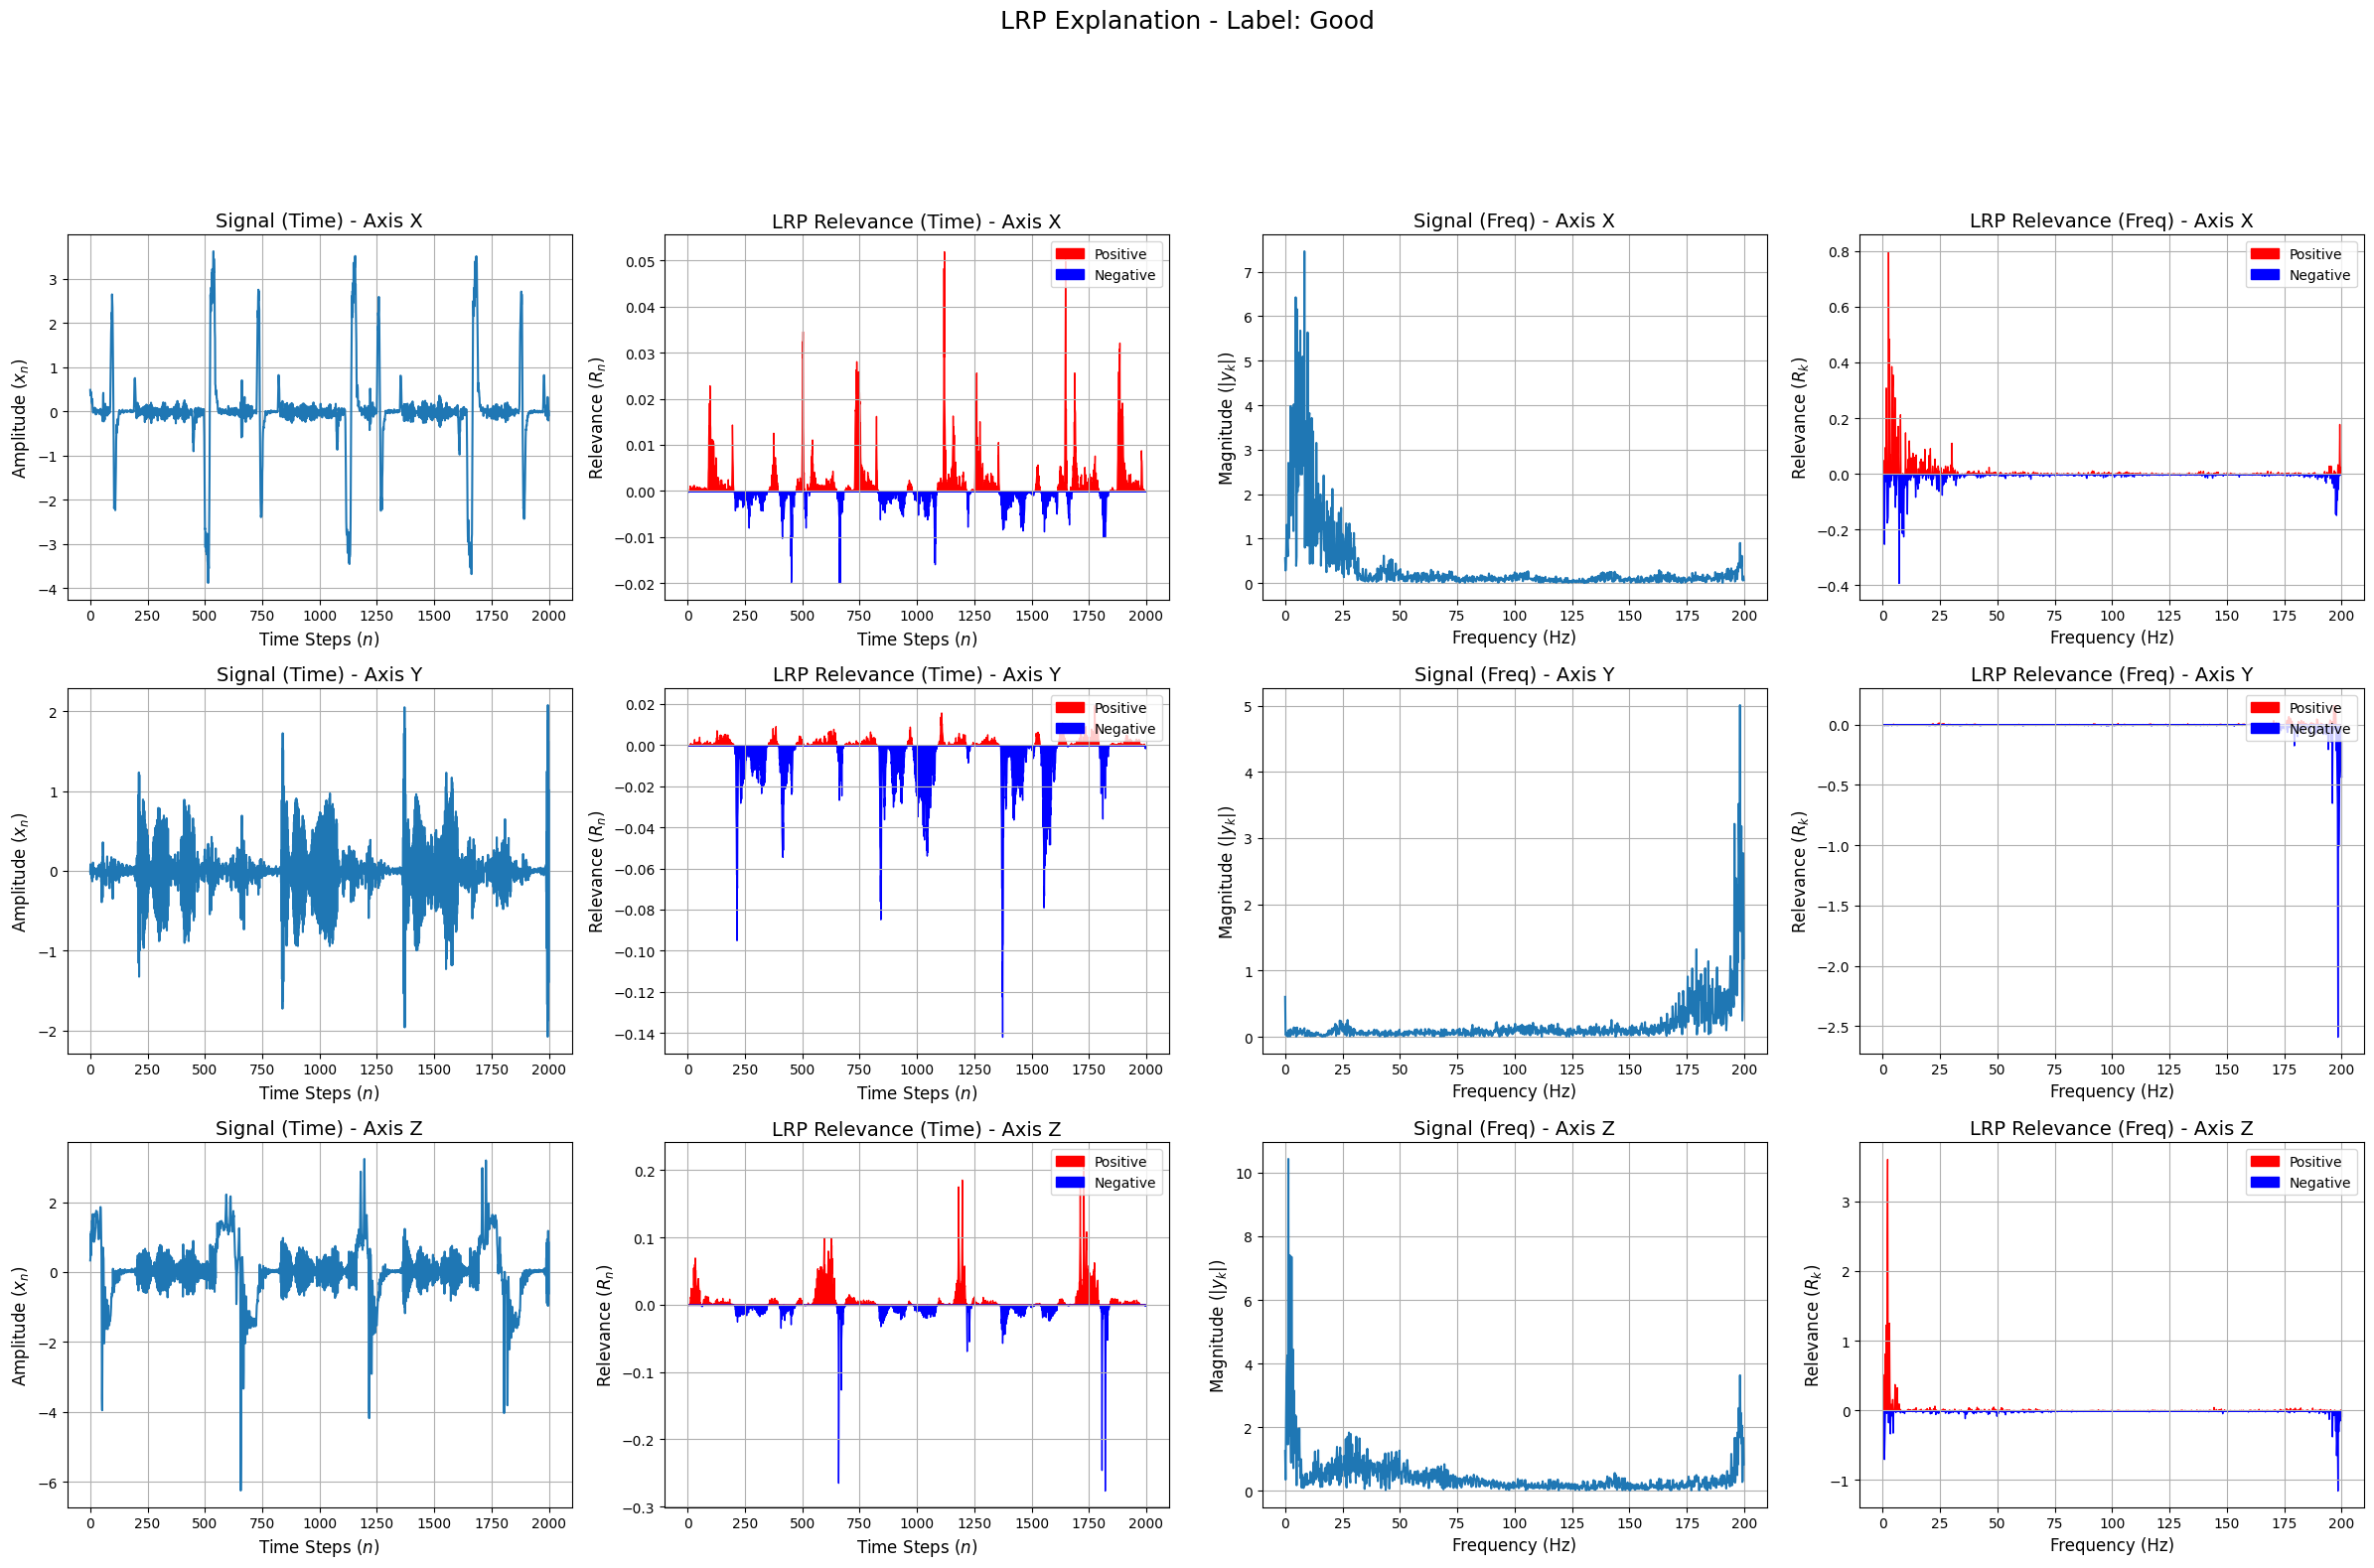

In [293]:
# Visualize the results
visualize_lrp_time_freq(
        relevance_time=relevance_time,
        relevance_freq=relevance_freq,
        signal_freq=signal_freq,
        input_signal=input_signal,
        freqs=freqs,
        predicted_label=predicted_label,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

#### FFT-LRP implementation

In [294]:
relevance_time, relevance_freq, signal_freq, relevance_timefreq, signal_timefreq, input_signal, freqs, predicted_label = compute_lrp_relevance_with_fft(
        model=model,
        sample=sample,
        label=None,
        signal_length=2000,
        sampling_rate=400,
        compute_timefreq=True,
        window_shift=64,  # Increased to reduce memory usage
        window_width=128,
        window_shape="rectangle"
    )

Input sample shape: torch.Size([1, 3, 2000])
Target label: 0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
relevance_time_tensor shape before squeeze: (1, 3, 2000)
relevance_time shape after squeeze: (3, 2000)
input_signal shape: (3, 2000)
fft_lrp: Input relevance shape = (1, 2000), signal shape = (1, 2000)
fft_lrp: relevance_tensor shape = torch.Size([1, 2000]), signal_tensor shape = torch.Size([1, 2000])
fourier_transform: signal_tensor shape = torch.Size([1, 2000])
fourier_transform (FFT): signal_hat shape = torch.Size([1, 1001])
fft_lrp: signal_hat shape = torch.Size([1, 1001])
fft_lrp: relevance_normed shape = torch.Size([1, 2000])
fft_lrp: relevance_fft real part = tensor([[-4.1269,  0.1861, -1.8834,  ...,  0.4302,  2.3510,  1.3596]],
       device='cuda:0')
fft_lrp: relevance_fft imag part = tensor([[ 0.0000,  0.6500, -2.0624,  ..., -3.9740,  2.6604, -0.0000]],
       device='cuda:0')
fft_lrp: relevance_hat real part before cpu = tensor([[

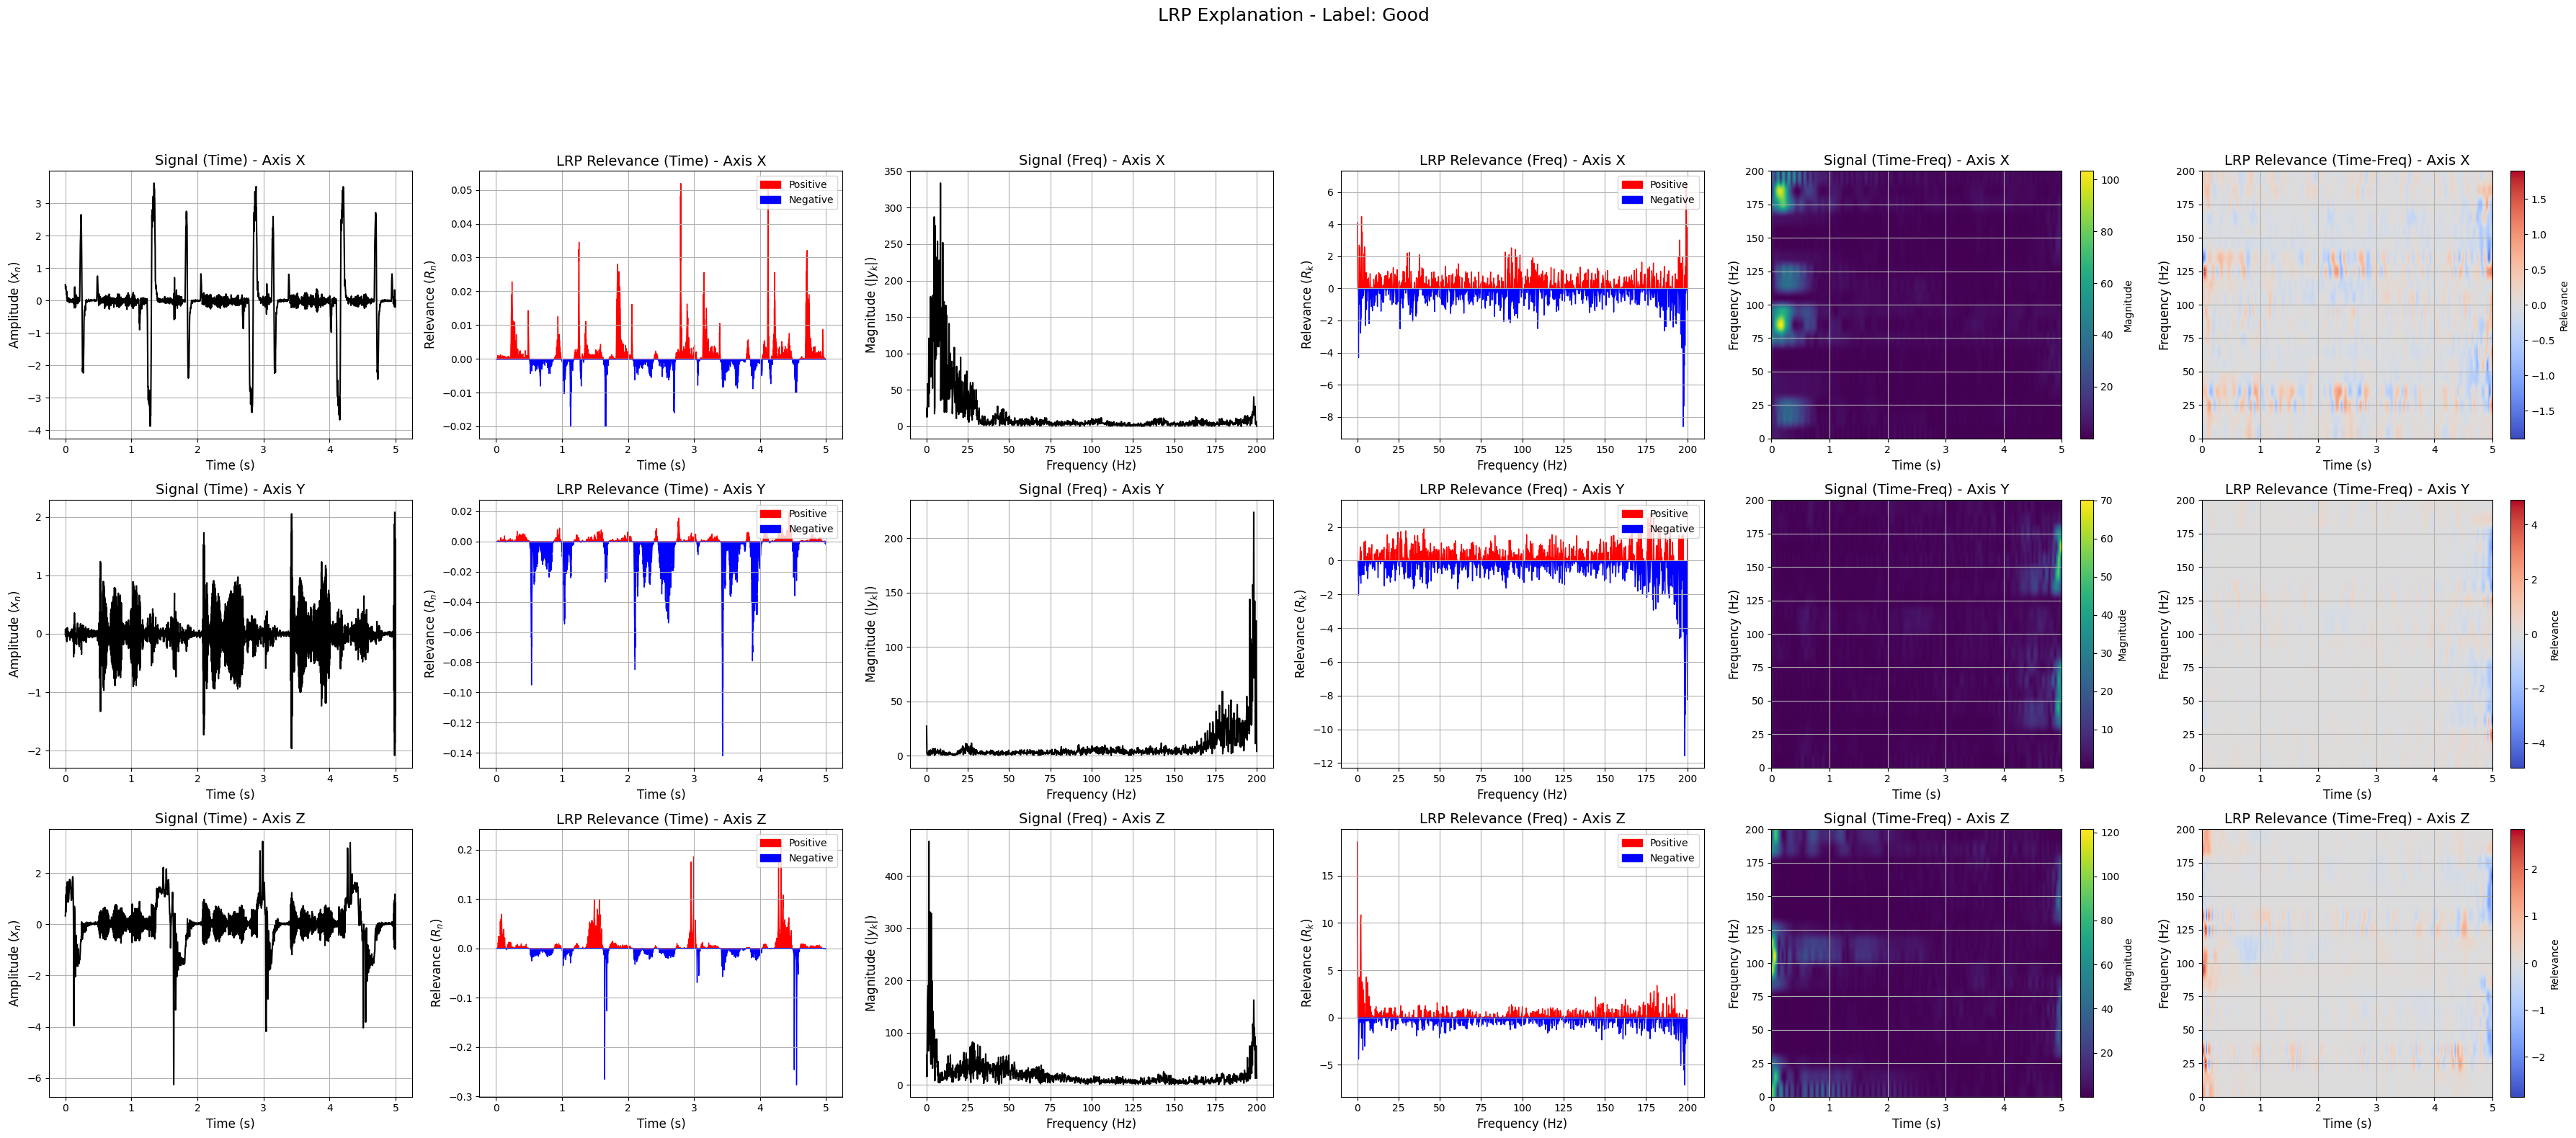

In [297]:
# Visualize
visualize_lrp_fft(
    relevance_time=relevance_time,
    relevance_freq=relevance_freq,
    signal_freq=signal_freq,
    relevance_timefreq=relevance_timefreq,
    signal_timefreq=signal_timefreq,
    input_signal=input_signal,
    freqs=freqs,
    predicted_label=predicted_label,
    signal_length=2000,
    sampling_rate=400,
    k_max=200
)

In [171]:
# Load a Bad sample

# Load a batch
sample_batch, label_batch = next(iter(train_loader))

# Choose a random index
random_index_b = random.randint(0, len(sample_batch) - 1)

# Select the random sample and its corresponding label
sample_b = sample_batch[random_index_b]  # Shape: (3, 10000)
label_b = label_batch[random_index_b]    # Shape: ()



sample_b = sample_b.to(device)
label_b = label_b.to(device)

_, predicted_label_b = predict_single(model, sample_b)


# Print the selected sample and label
print(f"Random Index: {random_index_b}, Predicted_label:{predicted_label_b}")
print(label_b, sample_b, label_b.shape, sample_b.shape)


Random Index: 43, Predicted_label:1
tensor(1, device='cuda:0') tensor([[-0.5357,  0.4816, -0.5209,  ..., -0.0449, -0.0270, -0.0291],
        [ 0.2212, -0.1592,  0.1250,  ..., -0.9107,  0.9681, -0.9114],
        [-0.1705,  0.0188, -0.1897,  ...,  0.4595, -0.6495,  0.4978]],
       device='cuda:0') torch.Size([]) torch.Size([3, 2000])


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 41 Label: Good


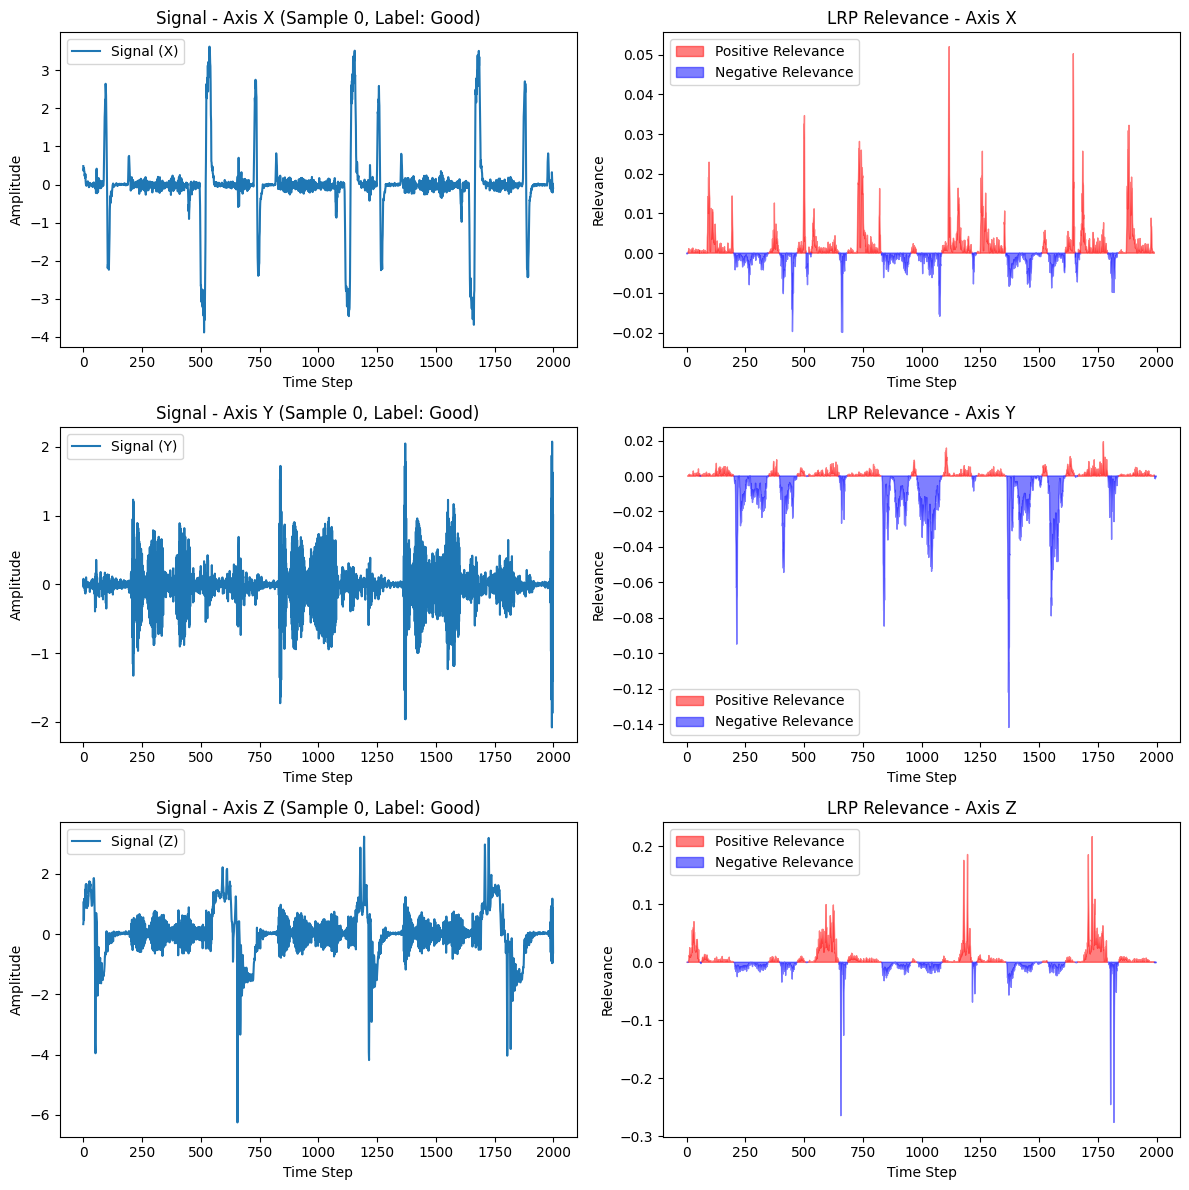

In [269]:
relevance, input_signal, final_label = compute_lrp_relevance_single_sample(
    model=model,
    sample=sample,  # Shape: (3, 10000) or torch tensor
    label=label,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index} Label: {'Good' if final_label == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_relevance_single_sample(
    signal=input_signal,
    relevance=relevance,
    label=final_label)

Min relevance: -0.1009003147482872, Max relevance: 0.0981021299958229
 Maximum Absolute Attribution in Axis 0: 0.06924362480640411
 Maximum Absolute Attribution in Axis 1: 0.1009003147482872
 Maximum Absolute Attribution in Axis 2: 0.0981021299958229


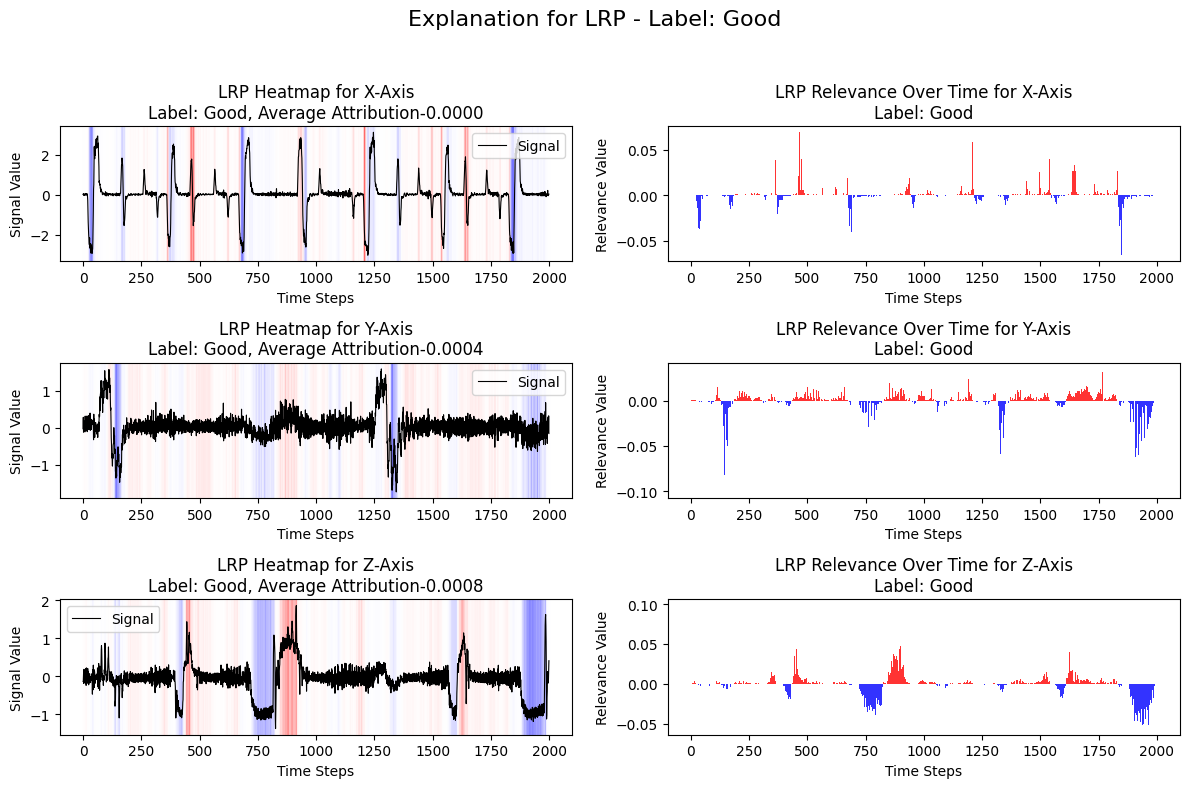

In [173]:

print(f"Min relevance: {np.min(relevance)}, Max relevance: {np.max(relevance)}")
visualize_combined_with_label_attribution(sample, relevance, label, "LRP")


Min relevance: -0.21126995980739594, Max relevance: 0.16644322872161865
 Maximum Absolute Attribution in Axis 0: 0.21126995980739594
 Maximum Absolute Attribution in Axis 1: 0.12458624690771103
 Maximum Absolute Attribution in Axis 2: 0.11811644583940506


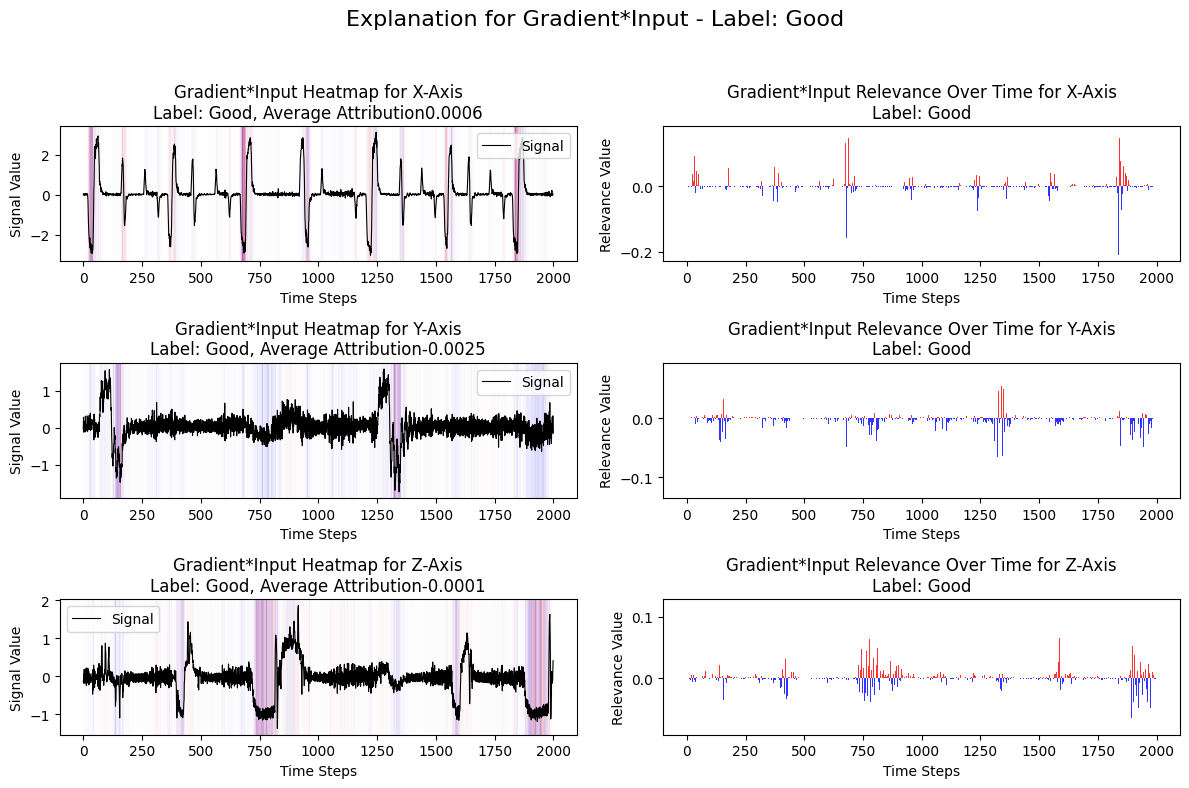

In [174]:

# Grad*Input
grad_input_attr, _ = xai_grad_times_input(model, sample)

print(f"Min relevance: {np.min(grad_input_attr.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, grad_input_attr, label, "Gradient*Input")


In [175]:
# Example usage
summary_g = summarize_attributions(grad_input_attr.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_g = []
for axis, values in summary_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_g.append(row)

# Create the DataFrame
df_summary_g = pd.DataFrame(data_g)

# Display the DataFrame as a table
print(df_summary_g)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0             849                  7.021364   
1  Axis 1             775                  1.784266   
2  Axis 2            1041                  5.264788   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.008270            1151                 -5.756375   
1                    0.002302            1225                 -6.847365   
2                    0.005057             959                 -5.510571   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.005001                     1.264989   
1                   -0.005590                    -5.063099   
2                   -0.005746                    -0.245783   

   Average Relevance (Pos + Neg)  
0                       0.000632  
1                      -0.002532  
2                      -0.000123  


Min relevance: -0.006094380281865597, Max relevance: 0.0037056284490972757
 Maximum Absolute Attribution in Axis 0: 0.006094380281865597
 Maximum Absolute Attribution in Axis 1: 0.003145426046103239
 Maximum Absolute Attribution in Axis 2: 0.00328190834261477


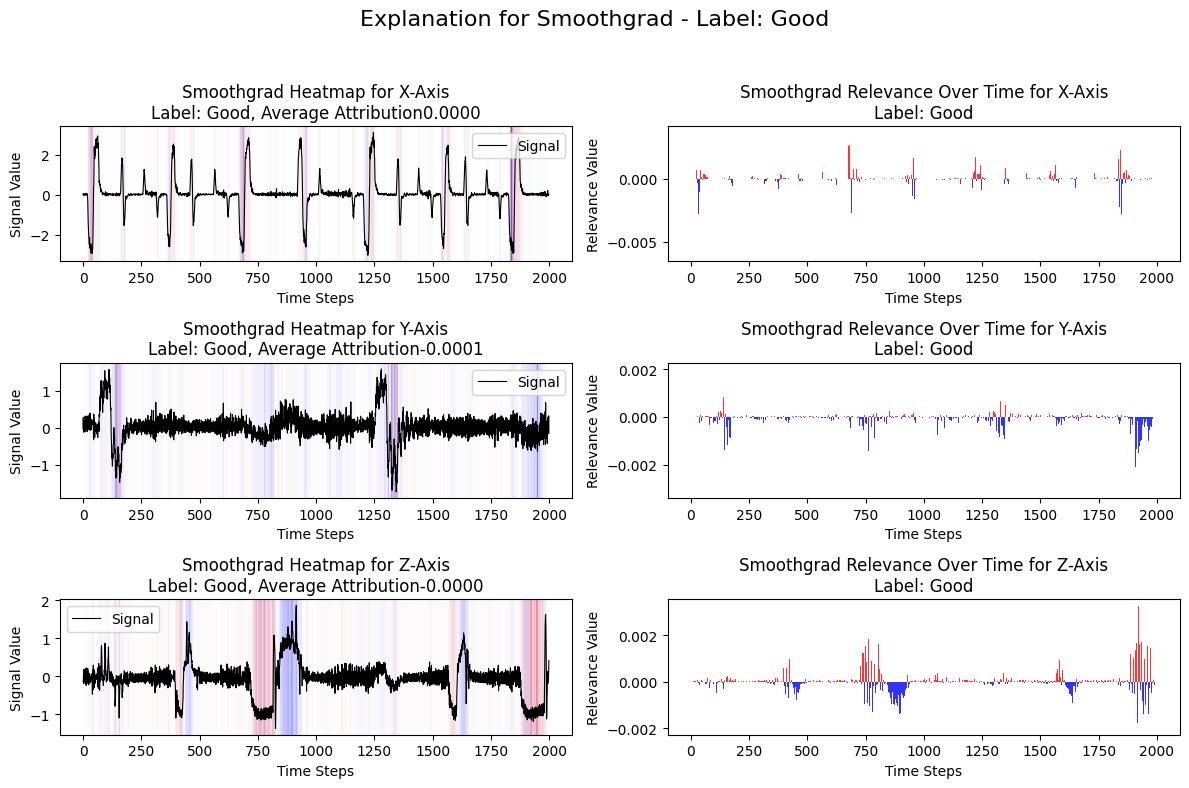

In [176]:

# SmoothGrad
smoothgrad_attr, _ = xai_smoothgrad(model, sample)
print(f"Min relevance: {np.min(smoothgrad_attr.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, smoothgrad_attr, label, "Smoothgrad")


Min relevance: -0.01138758659362793, Max relevance: 0.07065916061401367
 Maximum Absolute Attribution in Axis 0: 0.07065916061401367
 Maximum Absolute Attribution in Axis 1: 0.036263227462768555
 Maximum Absolute Attribution in Axis 2: 0.03854537010192871


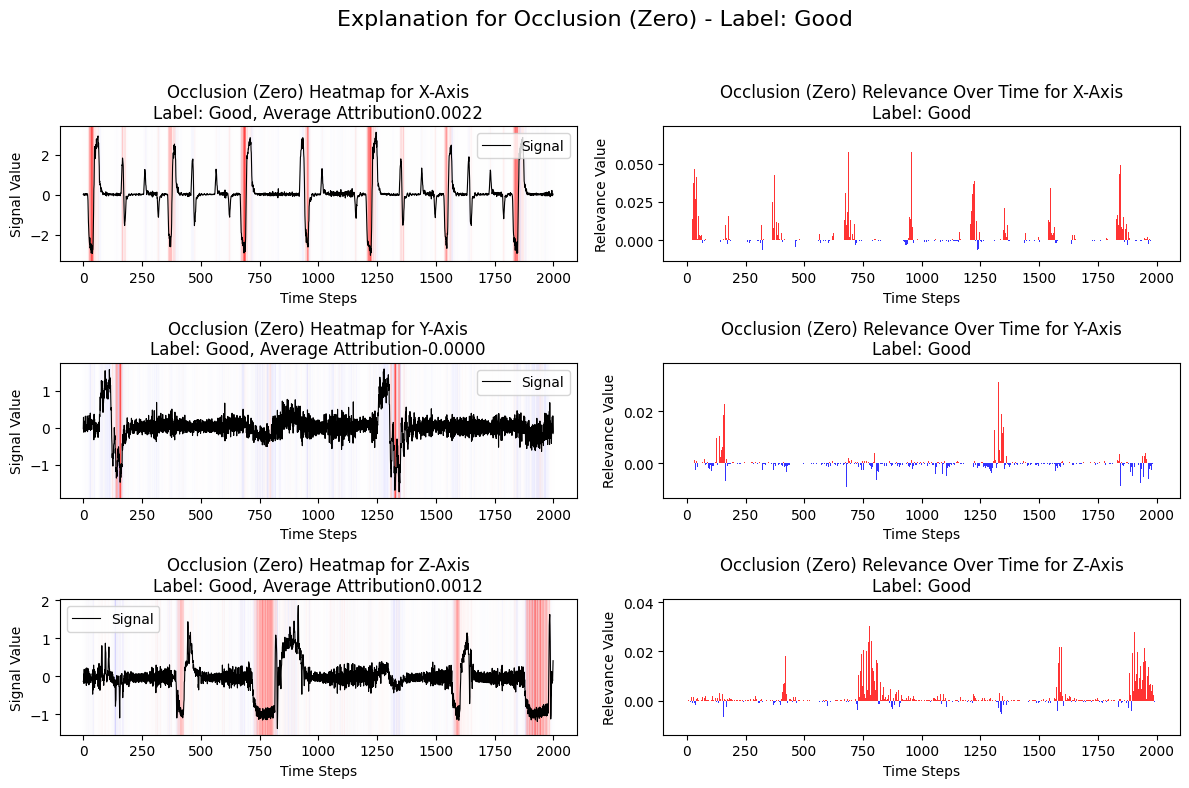

In [177]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero, _ = xai_occlusion_signal(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero, label, "Occlusion (Zero)")


Min relevance: -0.14610600471496582, Max relevance: 0.04204583168029785
 Maximum Absolute Attribution in Axis 0: 0.14610600471496582
 Maximum Absolute Attribution in Axis 1: 0.14610600471496582
 Maximum Absolute Attribution in Axis 2: 0.14610600471496582


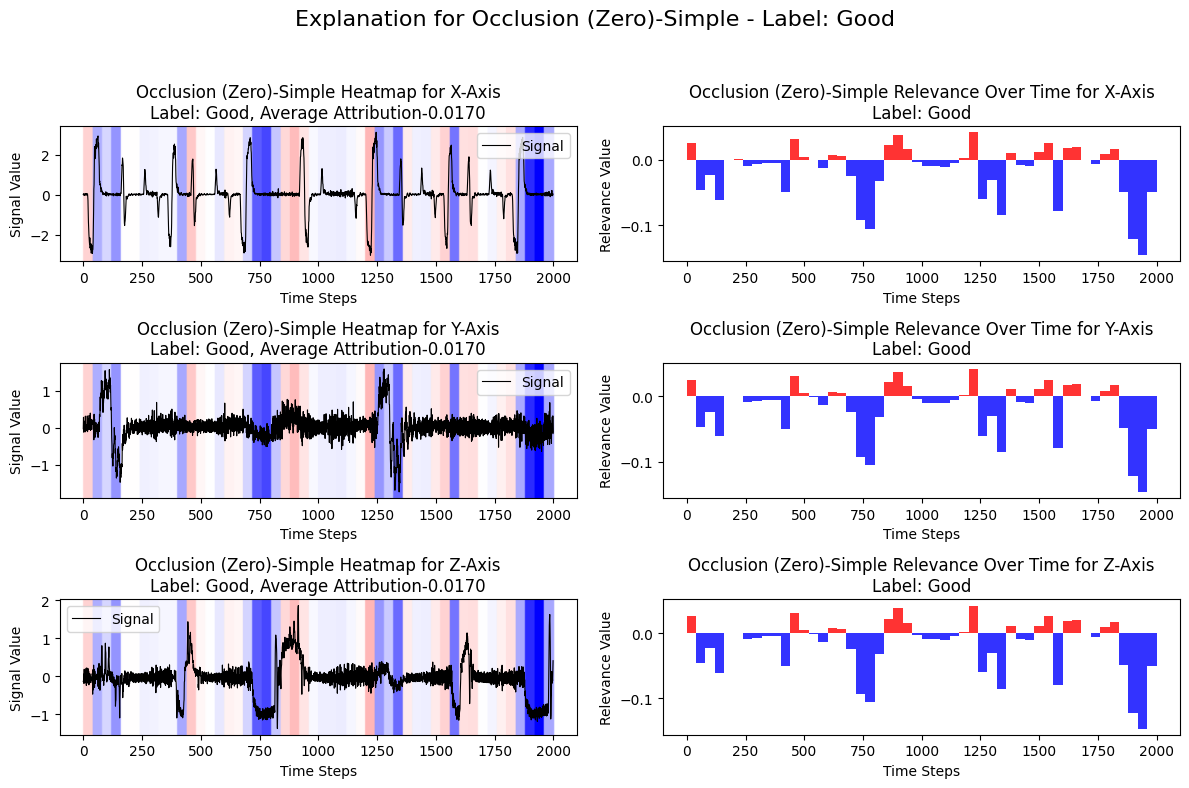

In [178]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = xai_occlusion_simple(model, sample, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (Zero)-Simple")


Min relevance: -0.19608330726623535, Max relevance: 0.1768031120300293
 Maximum Absolute Attribution in Axis 0: 0.19608330726623535
 Maximum Absolute Attribution in Axis 1: 0.19608330726623535
 Maximum Absolute Attribution in Axis 2: 0.19608330726623535


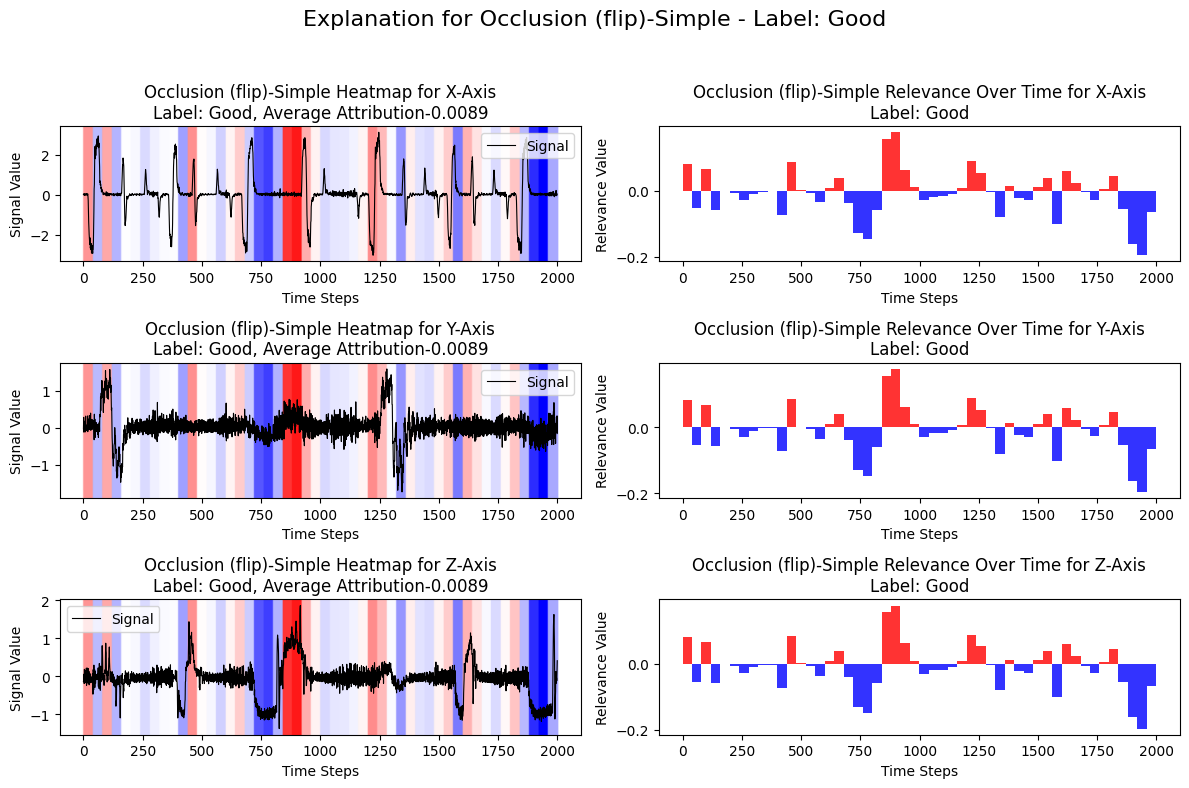

In [179]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_simple, _ = xai_occlusion_simple(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_zero_simple.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_simple.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_zero_simple, label, "Occlusion (flip)-Simple")


Min relevance: -0.02412247657775879, Max relevance: 0.11428141593933105
 Maximum Absolute Attribution in Axis 0: 0.11428141593933105
 Maximum Absolute Attribution in Axis 1: 0.07638001441955566
 Maximum Absolute Attribution in Axis 2: 0.07971692085266113


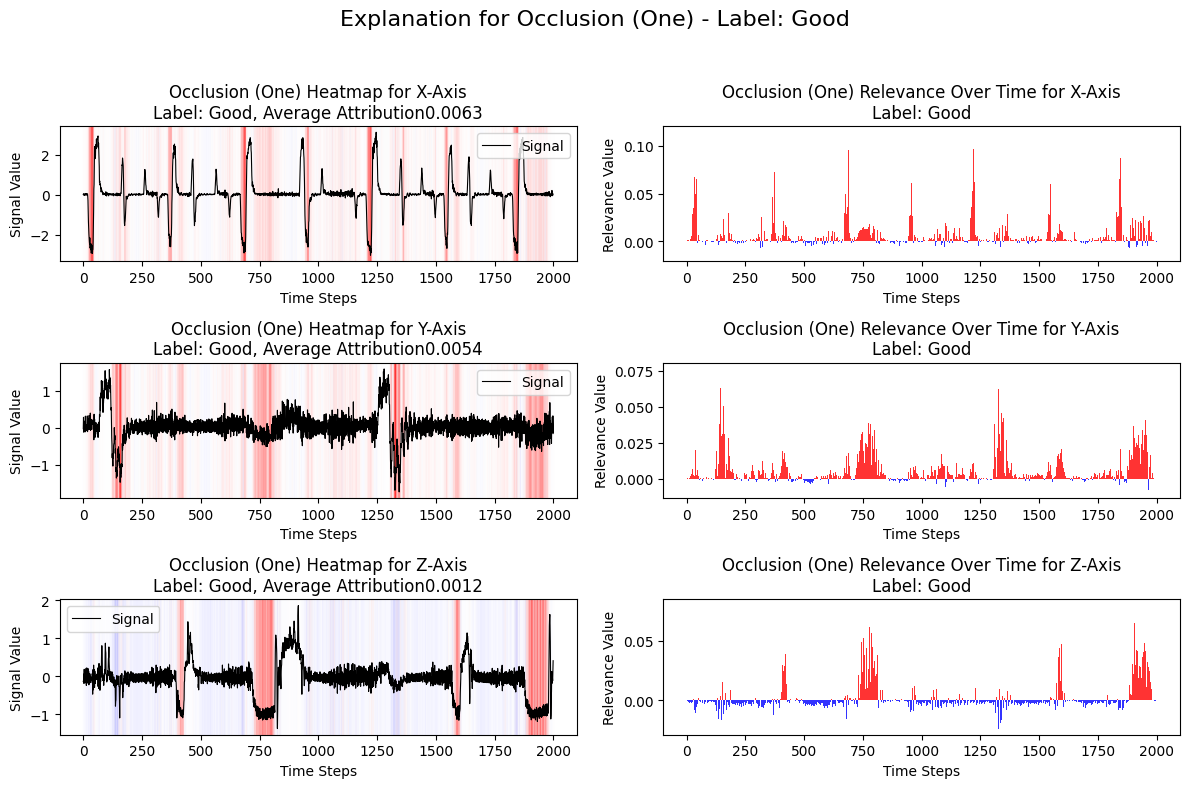

In [180]:
# Occlusion (one occlusion)
occlusion_attr_one, _ = xai_occlusion_signal(model, sample, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_one, label, "Occlusion (One)")


Min relevance: -0.014105081558227539, Max relevance: 0.043964385986328125
 Maximum Absolute Attribution in Axis 0: 0.043964385986328125
 Maximum Absolute Attribution in Axis 1: 0.03411698341369629
 Maximum Absolute Attribution in Axis 2: 0.035536766052246094


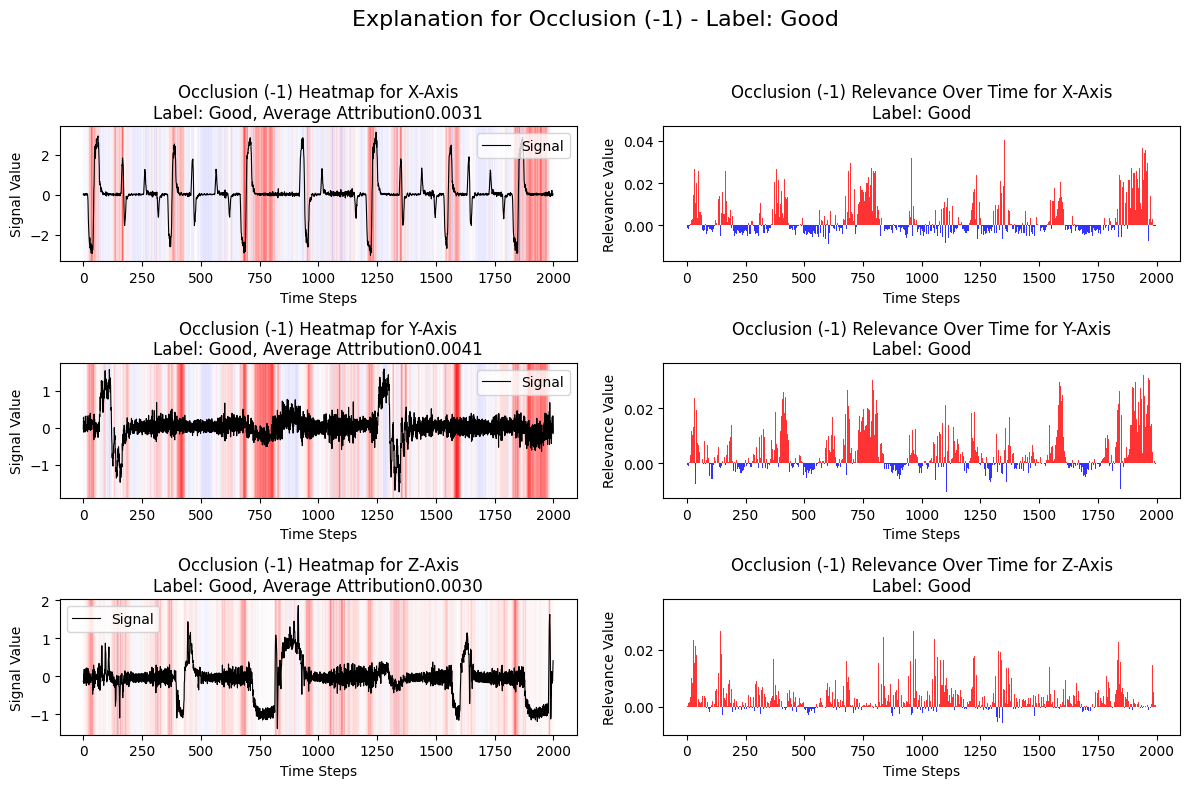

In [181]:
# Occlusion (-one occlusion)
occlusion_attr_mone, _ = xai_occlusion_signal(model, sample, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample, occlusion_attr_mone, label, "Occlusion (-1)")


Min relevance: -0.0204315185546875, Max relevance: 0.18921470642089844
 Maximum Absolute Attribution in Axis 0: 0.18921470642089844
 Maximum Absolute Attribution in Axis 1: 0.10996389389038086
 Maximum Absolute Attribution in Axis 2: 0.08325314521789551


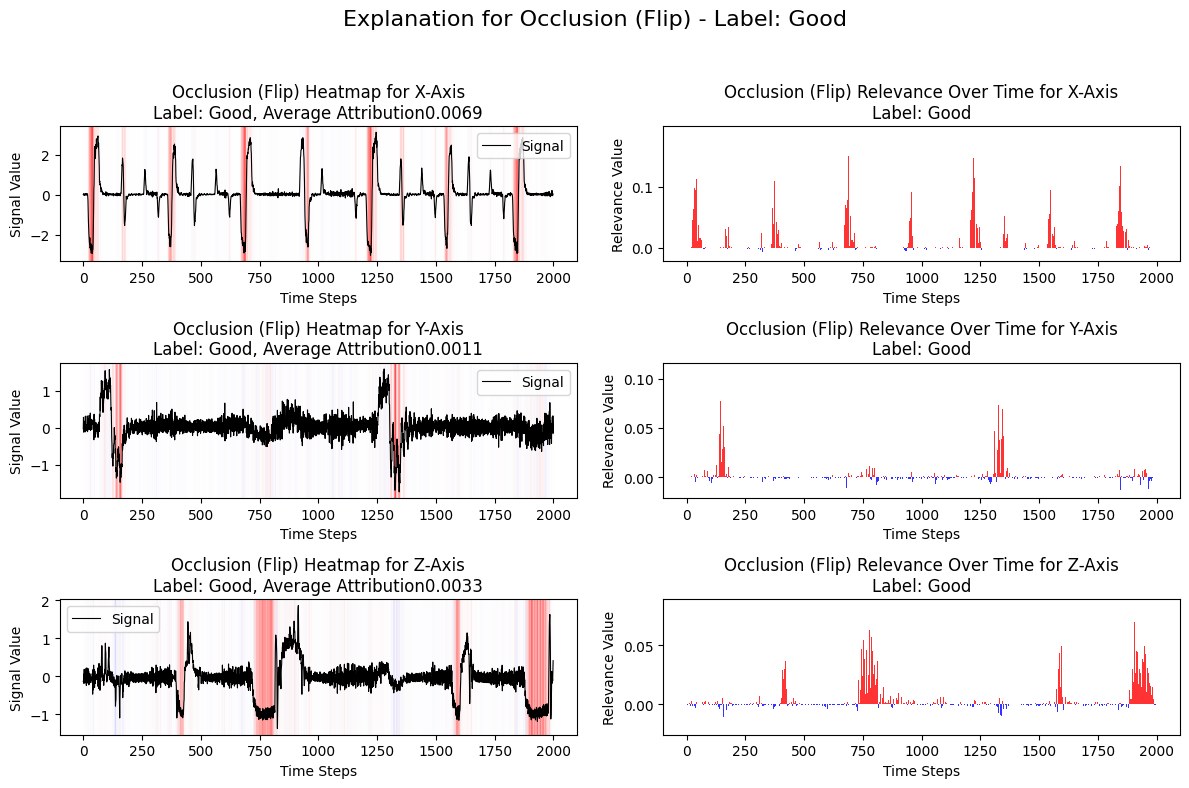

In [182]:
# Occlusion (flip occlusion)
occlusion_attr_flip, _ = xai_occlusion_signal(model, sample, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample, occlusion_attr_flip, label, "Occlusion (Flip)")


Min relevance: -0.047144725918769836, Max relevance: 0.022879615426063538
 Maximum Absolute Attribution in Axis 0: 0.047144725918769836
 Maximum Absolute Attribution in Axis 1: 0.018202323466539383
 Maximum Absolute Attribution in Axis 2: 0.013242383487522602


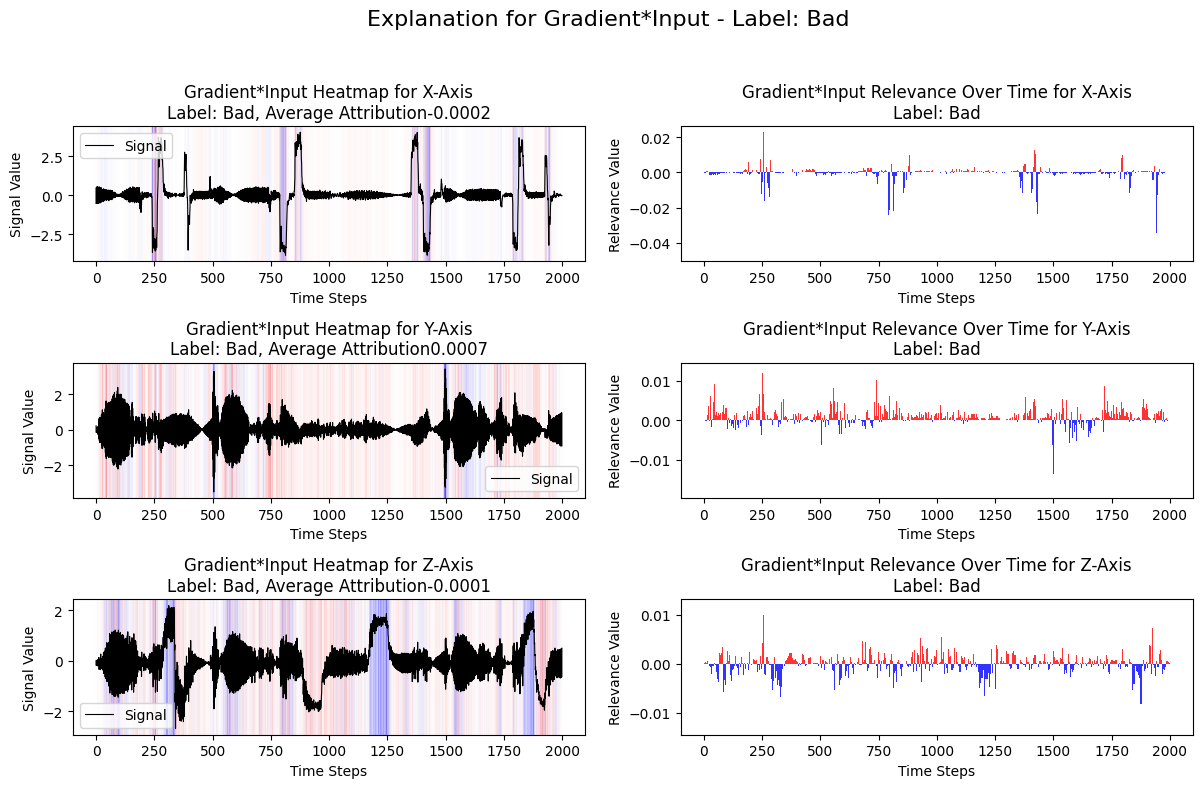

In [183]:
# Grad*Input
grad_input_attr_b, _ = xai_grad_times_input(model, sample_b)
print(f"Min relevance: {np.min(grad_input_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(grad_input_attr_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, grad_input_attr_b, label_b, "Gradient*Input")

In [184]:
# Example usage
summary_b_g = summarize_attributions(grad_input_attr_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data_b_g = []
for axis, values in summary_b_g.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_g.append(row)

# Create the DataFrame
df_summary_b_g = pd.DataFrame(data_b_g)

# Display the DataFrame as a table
print(df_summary_b_g)


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1124                  1.558043   
1  Axis 1            1403                  2.126502   
2  Axis 2            1069                  1.280478   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.001386             876                 -1.884985   
1                    0.001516             597                 -0.772552   
2                    0.001198             931                 -1.535369   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002152                    -0.326941   
1                   -0.001294                     1.353950   
2                   -0.001649                    -0.254891   

   Average Relevance (Pos + Neg)  
0                      -0.000163  
1                       0.000677  
2                      -0.000127  


Min relevance: -0.0026167340110987425, Max relevance: 0.0017843461828306317
 Maximum Absolute Attribution in Axis 0: 0.0023826411925256252
 Maximum Absolute Attribution in Axis 1: 0.0013571864692494273
 Maximum Absolute Attribution in Axis 2: 0.0026167340110987425


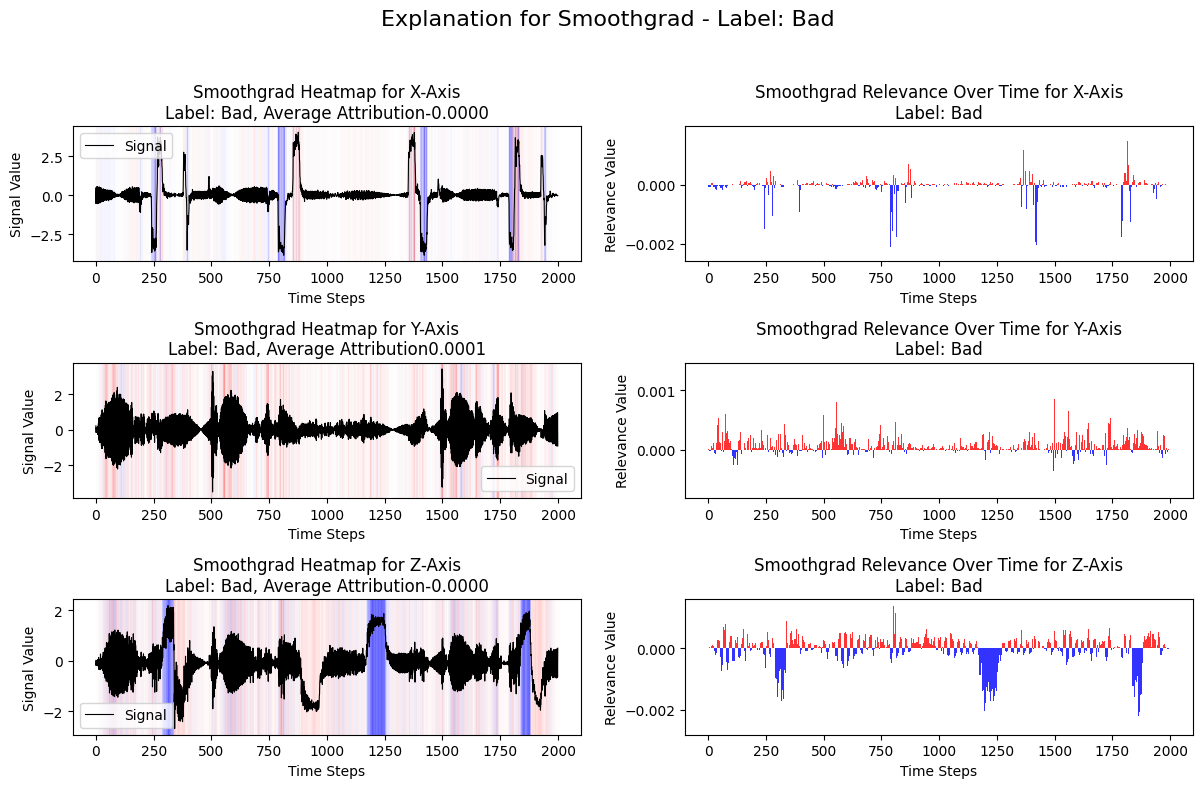

In [185]:
# SmoothGrad
smoothgrad_attr_b, _ = xai_smoothgrad(model, sample_b)
print(f"Min relevance: {np.min(smoothgrad_attr_b.detach().cpu().numpy())}, Max relevance: {np.max(smoothgrad_attr_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, smoothgrad_attr_b, label_b, "Smoothgrad")


In [186]:
# Example usage
summary_b_sg = summarize_attributions(smoothgrad_attr_b.detach().cpu().numpy())  # Pass your attributions here
# Flatten the summary dictionary and create a DataFrame
data_b_sg = []
for axis, values in summary_b_sg.items():
    row = {"Axis": axis}
    row.update(values)
    data_b_sg.append(row)

# Create the DataFrame
df_summary_b_sg = pd.DataFrame(data_b_sg)

# Display the DataFrame as a table
print(df_summary_b_sg)# Flatten the summary dictionary and create a DataFrame


     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1103                  0.097027   
1  Axis 1            1394                  0.159728   
2  Axis 2            1095                  0.282845   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000088             897                 -0.142998   
1                    0.000115             606                 -0.037405   
2                    0.000258             905                 -0.373897   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.000159                    -0.045971   
1                   -0.000062                     0.122323   
2                   -0.000413                    -0.091052   

   Average Relevance (Pos + Neg)  
0                      -0.000023  
1                       0.000061  
2                      -0.000046  


Min relevance: -0.017102479934692383, Max relevance: 0.006119966506958008
 Maximum Absolute Attribution in Axis 0: 0.017102479934692383
 Maximum Absolute Attribution in Axis 1: 0.0050394535064697266
 Maximum Absolute Attribution in Axis 2: 0.006119966506958008


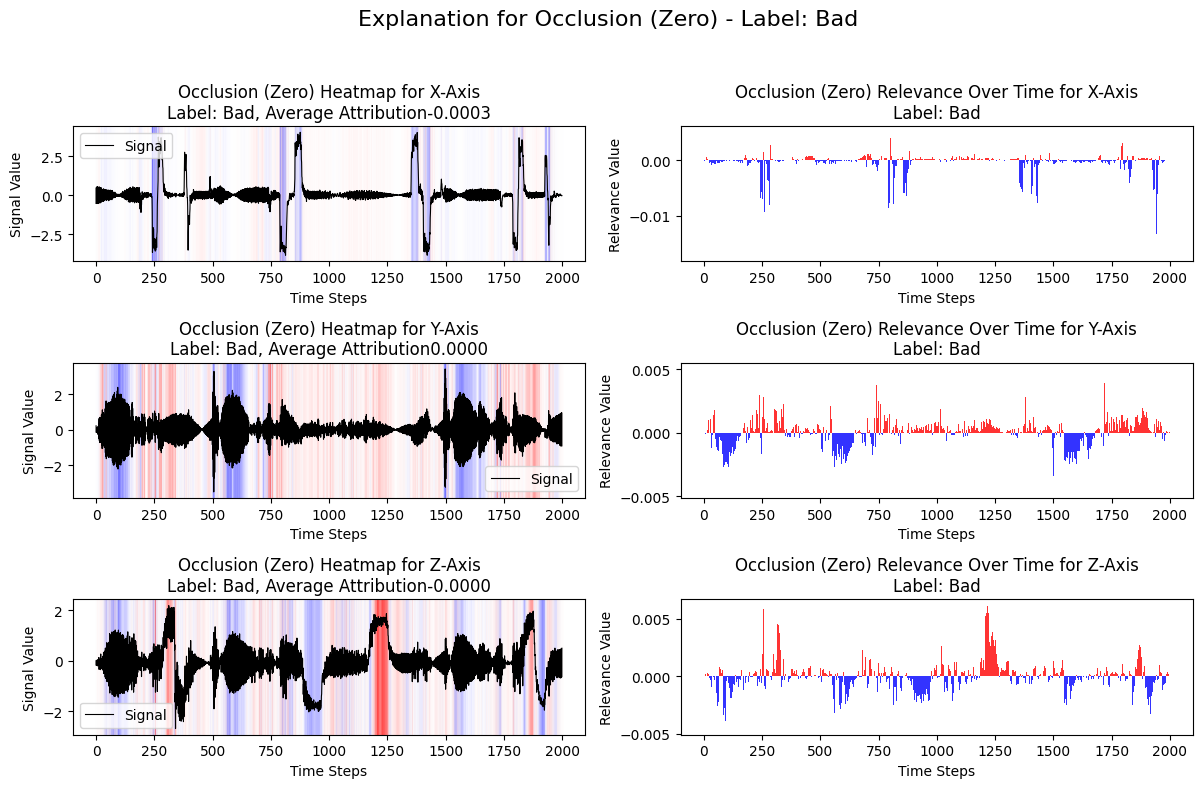

In [187]:
# Occlusion (zero-based occlusion)
occlusion_attr_zero_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="zero")
print(f"Min relevance: {np.min(occlusion_attr_zero_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_zero_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_zero_b, label_b, "Occlusion (Zero)")

Min relevance: -0.020725011825561523, Max relevance: 0.009370088577270508
 Maximum Absolute Attribution in Axis 0: 0.020725011825561523
 Maximum Absolute Attribution in Axis 1: 0.0072689056396484375
 Maximum Absolute Attribution in Axis 2: 0.009370088577270508


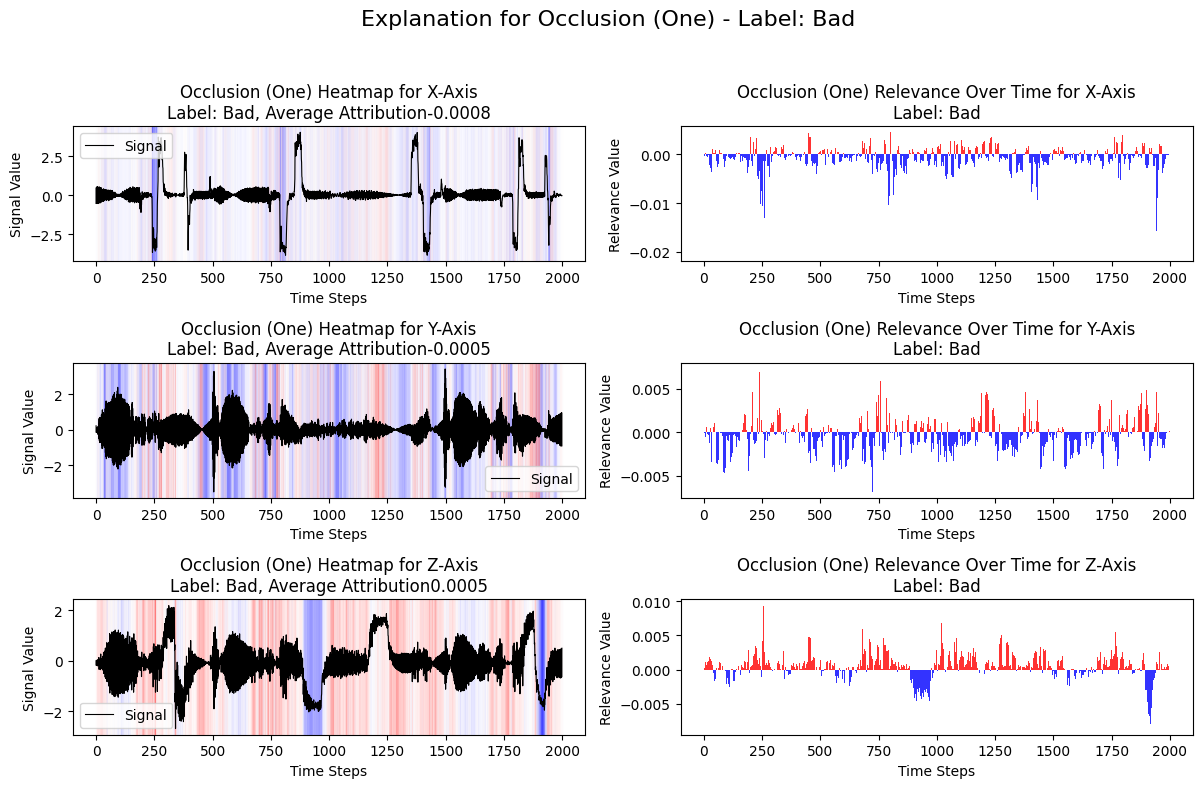

In [188]:
# Occlusion (one occlusion)
occlusion_attr_one_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="one")
print(f"Min relevance: {np.min(occlusion_attr_one_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_one_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_one_b, label_b, "Occlusion (One)")

Min relevance: -0.012438297271728516, Max relevance: 0.009885311126708984
 Maximum Absolute Attribution in Axis 0: 0.012438297271728516
 Maximum Absolute Attribution in Axis 1: 0.008310317993164062
 Maximum Absolute Attribution in Axis 2: 0.009885311126708984


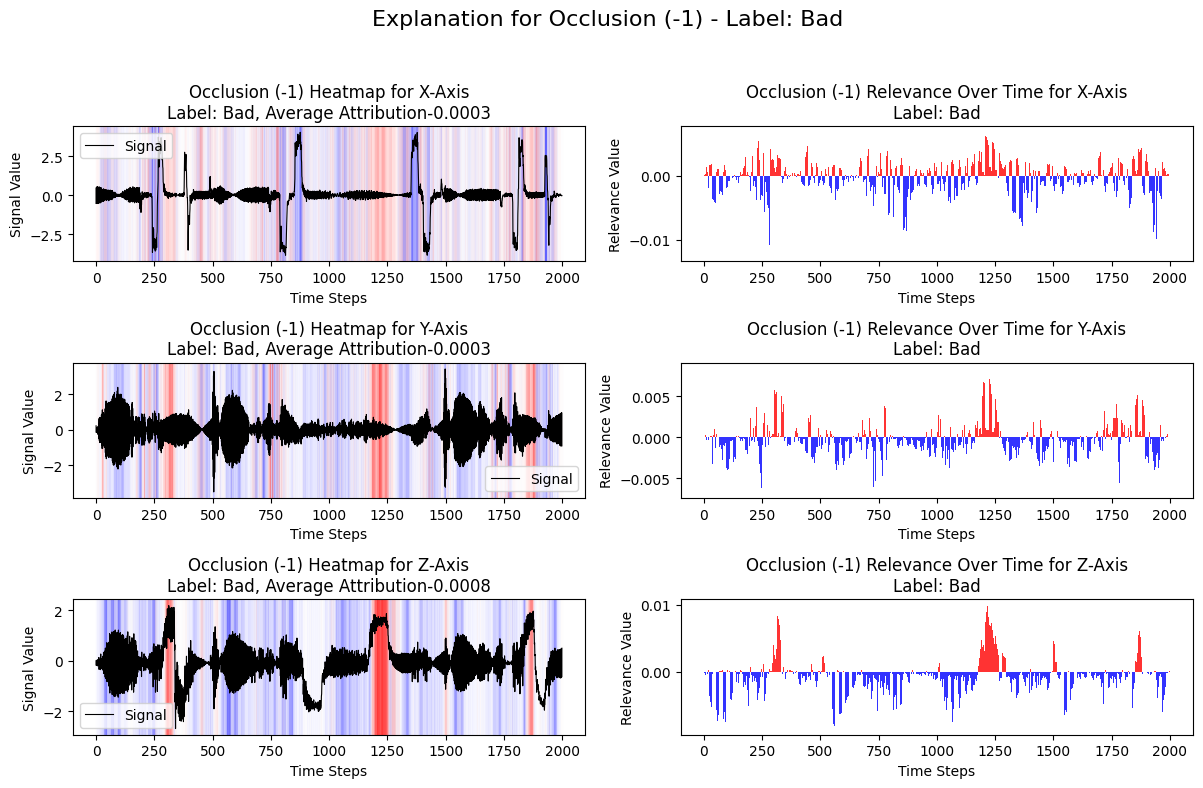

In [189]:
# Occlusion (-one occlusion)
occlusion_attr_mone_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="mone")
print(f"Min relevance: {np.min(occlusion_attr_mone_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_mone_b.detach().cpu().numpy())}")
visualize_combined_with_label_attribution(sample_b, occlusion_attr_mone_b, label_b, "Occlusion (-1)")

Min relevance: -0.024416685104370117, Max relevance: 0.012345314025878906
 Maximum Absolute Attribution in Axis 0: 0.024416685104370117
 Maximum Absolute Attribution in Axis 1: 0.007341146469116211
 Maximum Absolute Attribution in Axis 2: 0.012345314025878906


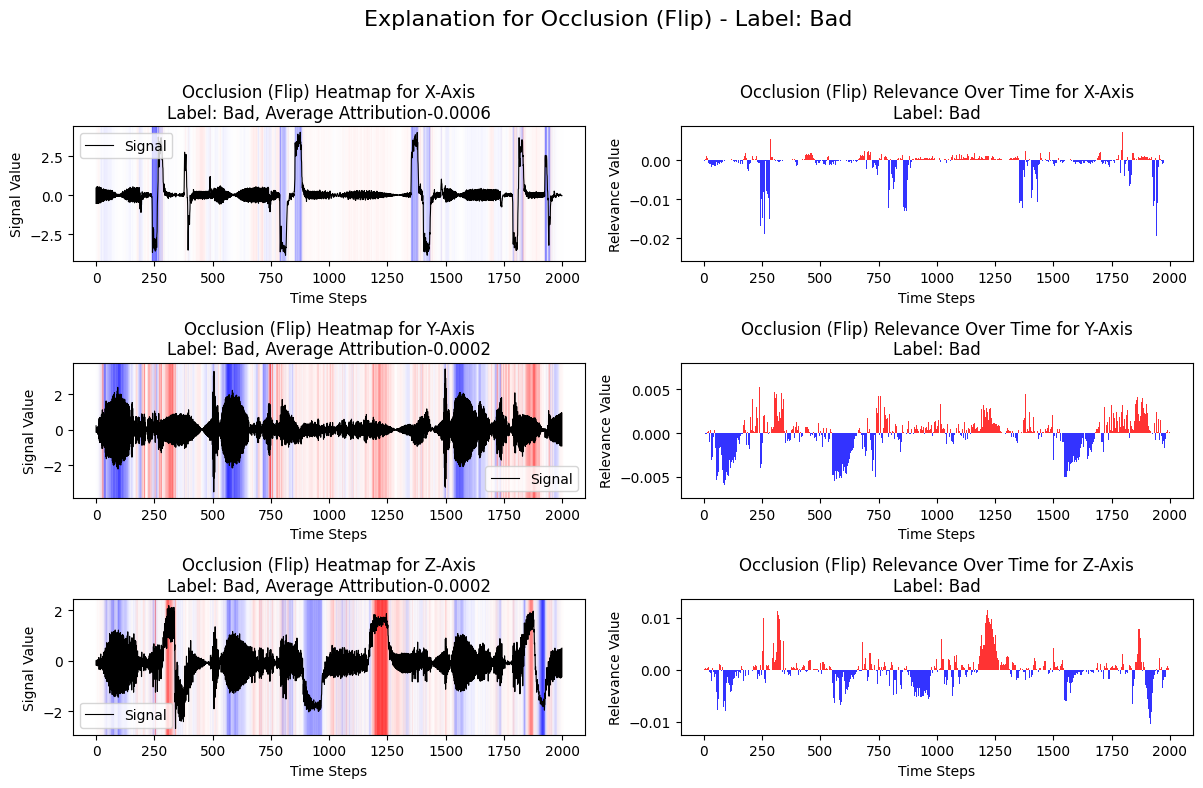

In [190]:

# Occlusion (e.g., zero-based occlusion)
occlusion_attr_flip_b, _ = xai_occlusion_signal(model, sample_b, occlusion_type="flip")
print(f"Min relevance: {np.min(occlusion_attr_flip_b.detach().cpu().numpy())}, Max relevance: {np.max(occlusion_attr_flip_b.detach().cpu().numpy())}")

visualize_combined_with_label_attribution(sample_b, occlusion_attr_flip_b, label_b, "Occlusion (Flip)")


In [191]:
summary_b_of = summarize_attributions(occlusion_attr_flip_b.detach().cpu().numpy())  # Pass your attributions here

# Flatten the summary dictionary and create a DataFrame
data = []
for axis, values in summary_b_of.items():
    row = {"Axis": axis}
    row.update(values)
    data.append(row)

# Create the DataFrame
df_summary = pd.DataFrame(data)

# Display the DataFrame as a table
print(df_summary)

     Axis  Positive Count  Total Positive Relevance  \
0  Axis 0            1015                  0.693083   
1  Axis 1            1073                  1.209407   
2  Axis 2             973                  1.602722   

   Average Positive Relevance  Negative Count  Total Negative Relevance  \
0                    0.000683             984                 -1.977870   
1                    0.001127             926                 -1.555199   
2                    0.001647            1025                 -1.957173   

   Average Negative Relevance  Total Relevance (Pos + Neg)  \
0                   -0.002010                    -1.284787   
1                   -0.001679                    -0.345793   
2                   -0.001909                    -0.354451   

   Average Relevance (Pos + Neg)  
0                      -0.000643  
1                      -0.000173  
2                      -0.000177  


Sample device: cuda:0
Model device: cuda:0
Target device: cuda:0
Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
Sample 43 Label: Bad


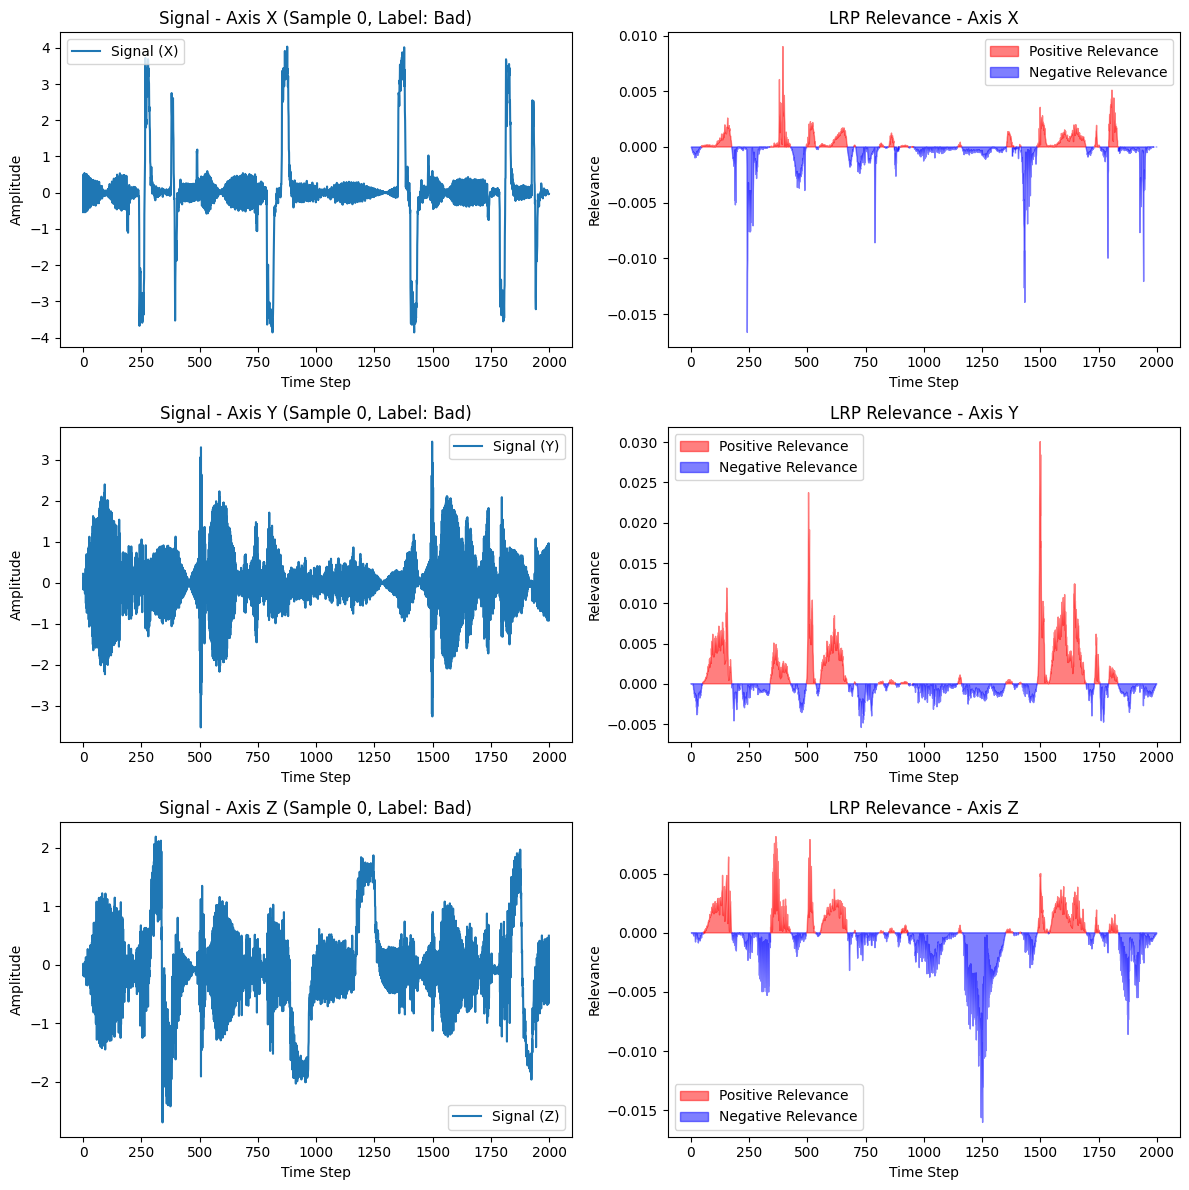

In [192]:
relevance_b, input_signal_b, final_label_b = compute_lrp_relevance_single_sample(
    model=model,
    sample=sample_b,  # Shape: (3, 10000) or torch tensor
    label=label_b,  # Use true label or None for prediction
    device=device
)
print(f"Sample {random_index_b} Label: {'Good' if final_label_b == 0 else 'Bad'}")

# Visualize LRP relevances (use your existing `visualize_lrp_relevance_single_sample` function)
visualize_lrp_relevance_single_sample(
    signal=input_signal_b,
    relevance=relevance_b,
    label=final_label_b)

Min relevance: -0.016637751832604408, Max relevance: 0.030074894428253174
 Maximum Absolute Attribution in Axis 0: 0.016637751832604408
 Maximum Absolute Attribution in Axis 1: 0.030074894428253174
 Maximum Absolute Attribution in Axis 2: 0.016025900840759277


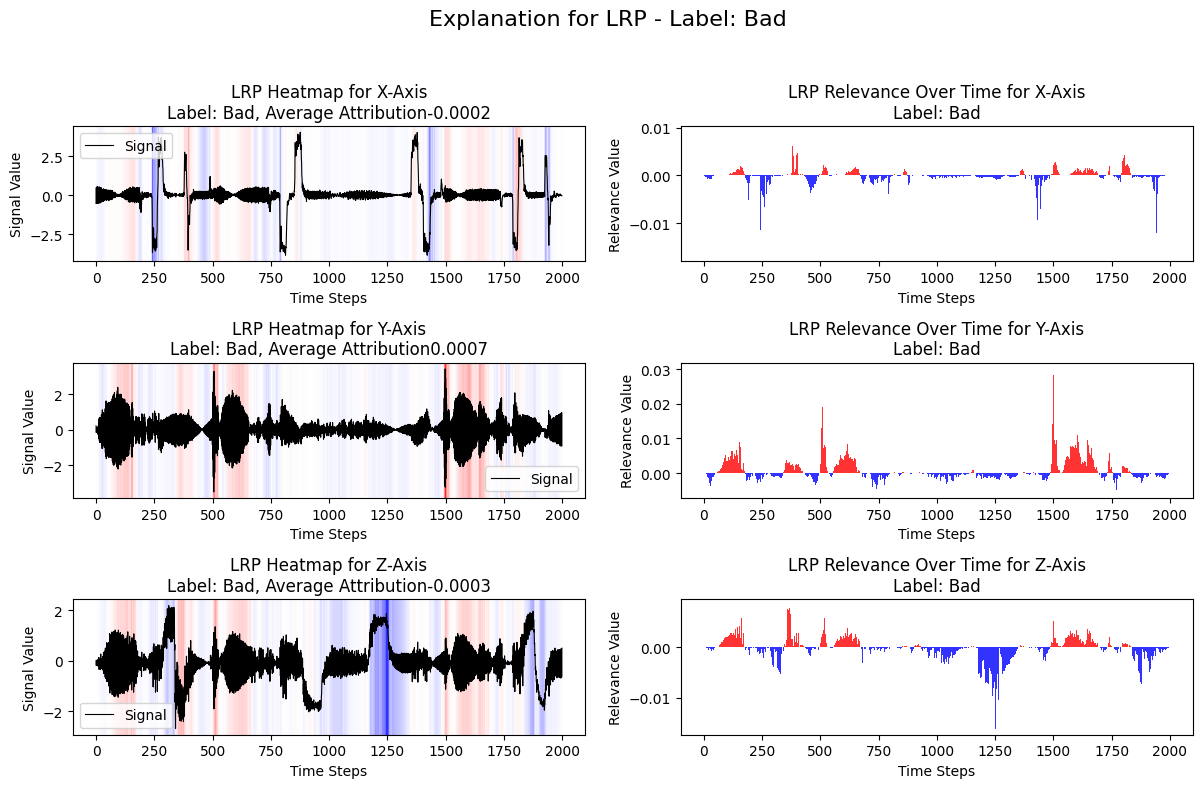

In [193]:

print(f"Min relevance: {np.min(relevance_b)}, Max relevance: {np.max(relevance_b)}")
visualize_combined_with_label_attribution(sample_b, relevance_b, label_b, "LRP")


In [194]:
relevance_time_b, relevance_freq_b, signal_freq_b, input_signal_b, freqs_b, predicted_label_b = compute_lrp_relevance_with_dft(
        model=model,
        sample=sample_b.cpu().detach().numpy(),  # Convert to NumPy for DFTLRP
        label=label_b.item(),
        device=device,
        signal_length=2000,
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )

Input device in zennit_relevance: cuda:0
Input device in zennit_relevance_lrp: cuda:0
3
1001


E:\Thesis\Datasets\CNC\dft_lrp.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(input, dtype=dtype)


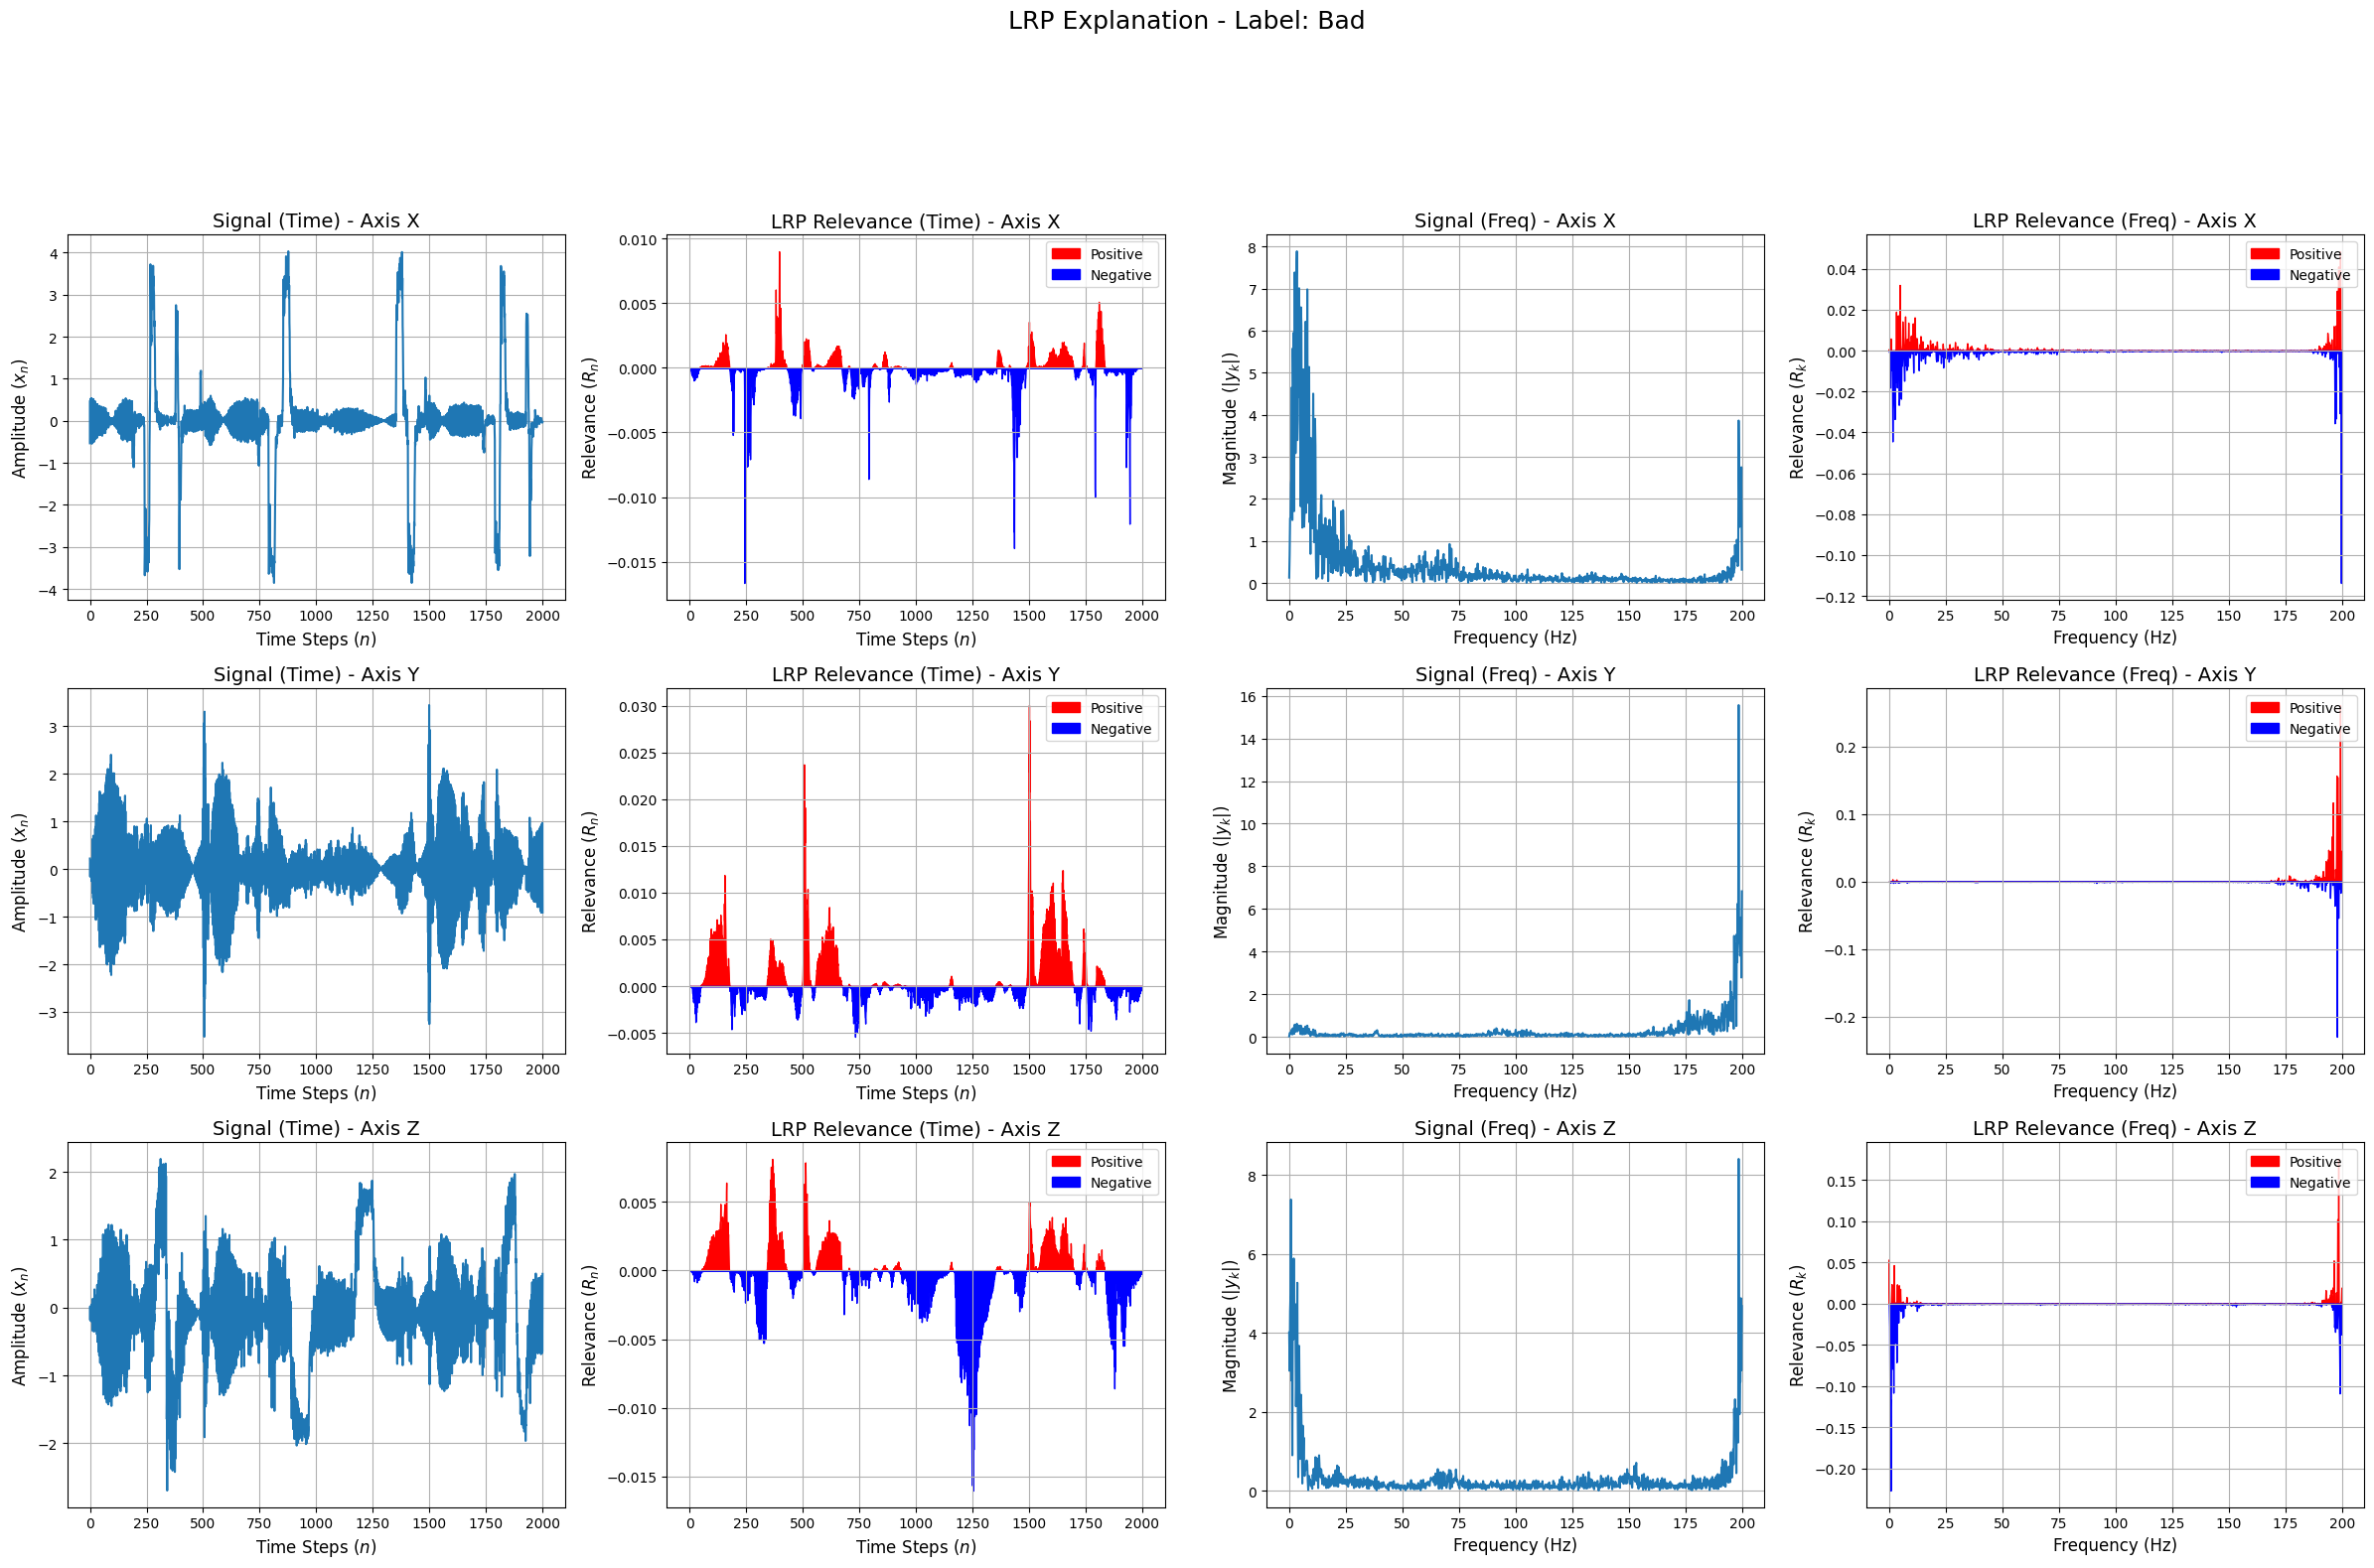

In [195]:
# Visualize the results
visualize_lrp_time_freq(
        relevance_time=relevance_time_b,
        relevance_freq=relevance_freq_b,
        signal_freq=signal_freq_b,
        input_signal=input_signal_b,
        freqs=freqs_b,
        predicted_label=predicted_label_b,
        k_max=1000,  # Plot up to 1000 Hz
        sampling_rate=400  # Placeholder, replace with your actual sampling rate
    )